In [1]:
import requests
import json
import time
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Preprocessing
Notre projet portera sur le jeu League of Legends. C’est un jeu d’équipe en ligne
en 5 contre 5. Vous pouvez si vous le souhaitez regarder un tutoriel de 3 minutes
si vous avez envie de vous familiariser avec le jeu pour avoir une meilleure
compréhension globale sur le thème de notre projet.
https://www.youtube.com/watch?v=0MEOdboHk8o&ab_channel=GentleMates

# 1 - Collection de notre jeu de données

Pour collecter nos données, nous sommes directement allés les chercher à la source en se branchant à l’api du jeu. On y récupère les noms des meilleurs joueurs du serveur européen. On fait ce choix car ces parties de haut niveaux sont moins hasardeuses et il en découlera des données plus fiables.

Il faut aussi prendre en compte les restrictions de l’api concernant le nombre de requêtes, on a pour cela créé plusieurs comptes particuliers afin de faire des requêtes en parrallèles sur plus de comptes.

Nous avons séparé tout le processus de requêtes api dans le fichier api_process. Ce fichier contiendra le code en rapport direct avec les jalons et le rendu final du projet.

# Update depuis le jalon 2 : 
Même si nous en avions l'intuition, prédire l'issue d'une partie en prenant ses caractéristiques à l'instant final de la partie était trop simple (environ 1 d'accuracy dès la régression logistique en cross validation).

On revoit donc tout le dataset pour prendre des informations à un instant t (exemple ici : 15 minutes) de la partie pour en prédire son issue. On aura donc des résultats plus pertinents avec une vraie utilité avec un peu plus de challenge.

Le processus de récolte de données, de filtrage des parties de moins de 15 minutes etc.. est disponible dans le notebook api_processs. 

On a gardé une trace de nos anciennes accuracys dans le fichier accuracy_with_single_feature.txt.



In [2]:
data = pd.read_csv('data_15min_final.csv')
target = data['winningTeam']
data.drop(columns='winningTeam', inplace=True)

In [3]:
data

Team1.championStats.abilityHaste  Team1.championStats.abilityPower  \
0                                    0                               177   
1                                    0                               185   
2                                    0                               186   
3                                    0                               195   
4                                    0                               230   
...                                ...                               ...   
9813                                 0                               334   
9814                                 0                               225   
9815                                 0                               456   
9816                                 0                               188   
9817                                 0                               288   

      Team1.championStats.armor  Team1.championStats.armorPen  \
0                           352                             0   
1                           446                             0   
2                           466                             0   
3                           307                             0   
4                           348                             0   
...                         ...                           ...   
9813                        307                             0   
9814                        362                             0   
9815                        380                             0   
9816                        393                             0   
9817                        419                             0   

      Team1.championStats.armorPenPercent  Team1.championStats.attackDamage  \
0                                       0                               628   
1                                       0                               551   
2                                       0                               603   
3                                       0                               746   
4                                      30                               759   
...                                   ...                               ...   
9813                                    0                               867   
9814                                    0                               664   
9815                                    0                               817   
9816                                    0                               651   
9817                                    0                               520   

      Team1.championStats.attackSpeed  \
0                                 817   
1                                 618   
2                                 826   
3                                 945   
4                                 635   
...                               ...   
9813                              512   
9814                              692   
9815                              818   
9816                              798   
9817                              713   

      Team1.championStats.bonusArmorPenPercent  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   
...                                        ...   
9813                                         0   
9814                                         0   
9815                                         0   
9816                                         0   
9817                                         0   

      Team1.championStats.bonusMagicPenPercent  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                  

In [4]:
data.describe()

Team1.championStats.abilityHaste  Team1.championStats.abilityPower  \
count                            9818.0                       9818.000000   
mean                                0.0                        235.988389   
std                                 0.0                        102.364094   
min                                 0.0                          0.000000   
25%                                 0.0                        161.000000   
50%                                 0.0                        222.000000   
75%                                 0.0                        299.000000   
max                                 0.0                        776.000000   

       Team1.championStats.armor  Team1.championStats.armorPen  \
count                9818.000000                        9818.0   
mean                  367.605419                           0.0   
std                    51.235050                           0.0   
min                   263.000000                           0.0   
25%                   331.000000                           0.0   
50%                   360.000000                           0.0   
75%                   395.000000                           0.0   
max                   726.000000                           0.0   

       Team1.championStats.armorPenPercent  Team1.championStats.attackDamage  \
count                          9818.000000                       9818.000000   
mean                              1.377776                        633.077205   
std                               5.749763                         80.809331   
min                               0.000000                        410.000000   
25%                               0.000000                        575.000000   
50%                               0.000000                        628.000000   
75%                               0.000000                        683.000000   
max                              48.000000                       1092.000000   

       Team1.championStats.attackSpeed  \
count                      9818.000000   
mean                        750.664799   
std                          85.775827   
min                         512.000000   
25%                         690.000000   
50%                         740.000000   
75%                         799.000000   
max                        1283.000000   

       Team1.championStats.bonusArmorPenPercent  \
count                                    9818.0   
mean                                        0.0   
std                                         0.0   
min                                         0.0   
25%                                         0.0   
50%                                         0.0   
75%                                         0.0   
max                                         0.0   

       Team1.championStats.bonusMagicPenPercent  \
count                                    9818.0   
mean                                        0.0   
std                                         0.0   
min                                         0.0   
25%                                         0.0   
50%                                         0.0   
75%                                         0.0   
max                                         0.0   

       Team1.championStats.ccReduction  ...  Team2.goldPerSecond  \
count                      9818.000000  ...          9818.000000   
mean                         23.865349  ...            50.113058   
std                          24.537527  ...             2.596306   
min                         -30.000000  ...             0.000000   
25%                           0.000000  ...            50.000000   
50%                          19.000000  ...            50.000000   
75%                          37.000000  ...            50.000000   
max                         157.000000  ...           100.000000   

       Team2.jungleMinionsKilled  Team2.level  Team2.minionsKilled  \
count          

In [5]:
target

0       1
1       1
2       1
3       0
4       1
       ..
9813    1
9814    1
9815    0
9816    1
9817    0
Name: winningTeam, Length: 9818, dtype: int64

In [6]:
#count nan
data.isnull().sum().any()


False

In [7]:
target.isnull().sum().any()

False

# Visualisation du dataset

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle

In [9]:
data = pd.read_csv('data_15min_final.csv')
target = data['winningTeam']

In [10]:
target

0       1
1       1
2       1
3       0
4       1
       ..
9813    1
9814    1
9815    0
9816    1
9817    0
Name: winningTeam, Length: 9818, dtype: int64

# Histogrammes 

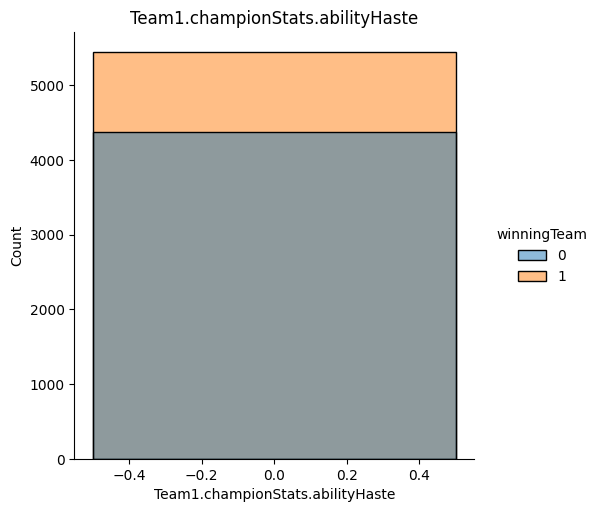

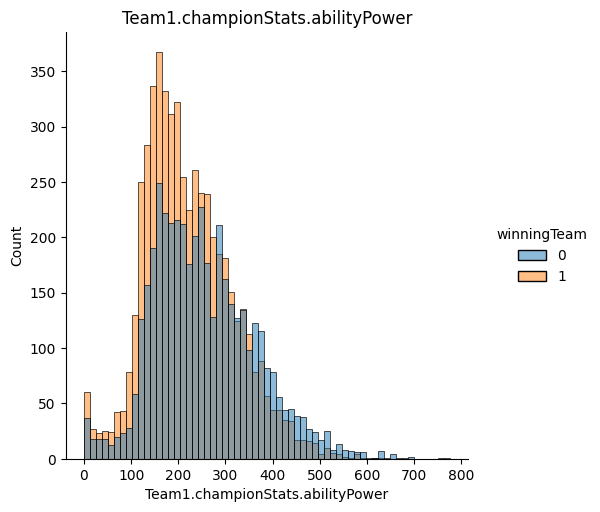

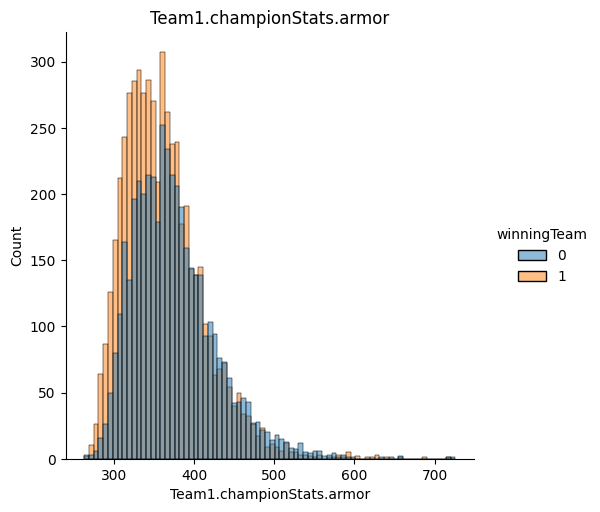

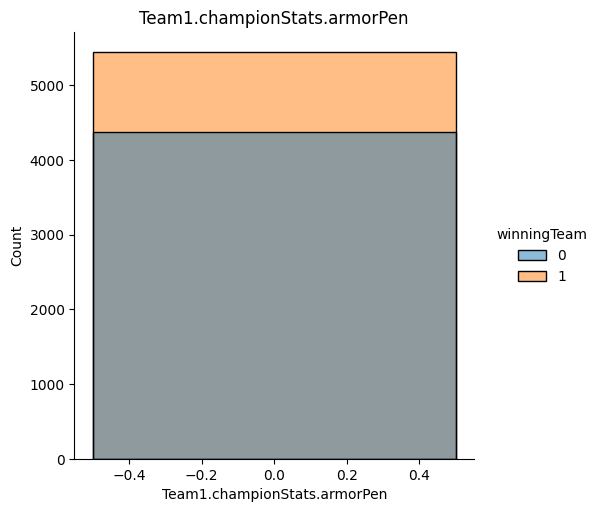

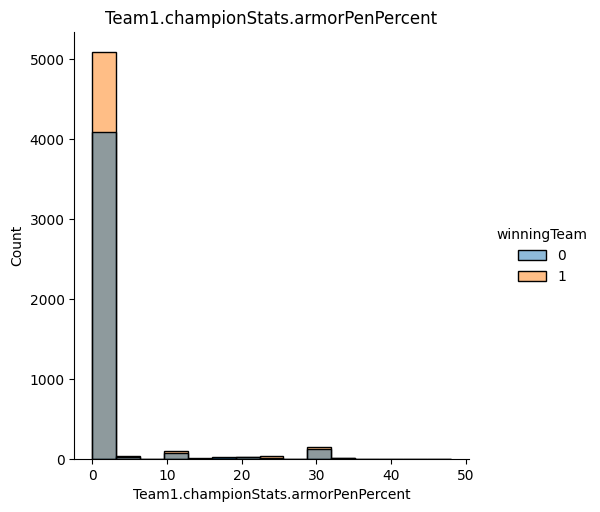

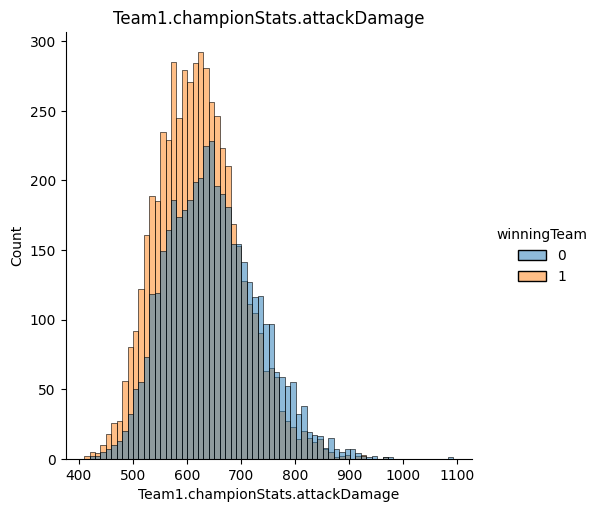

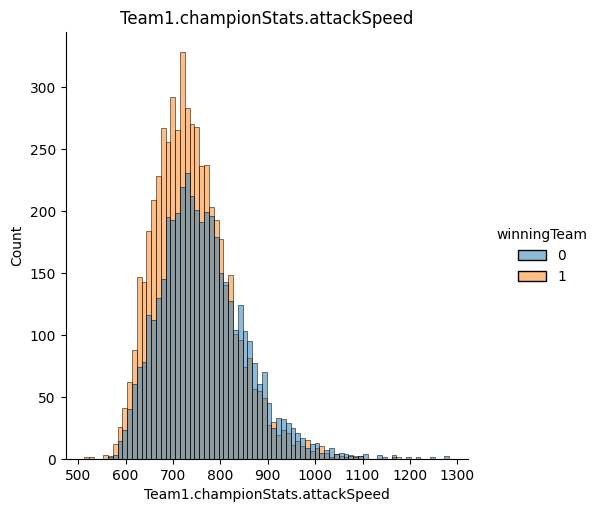

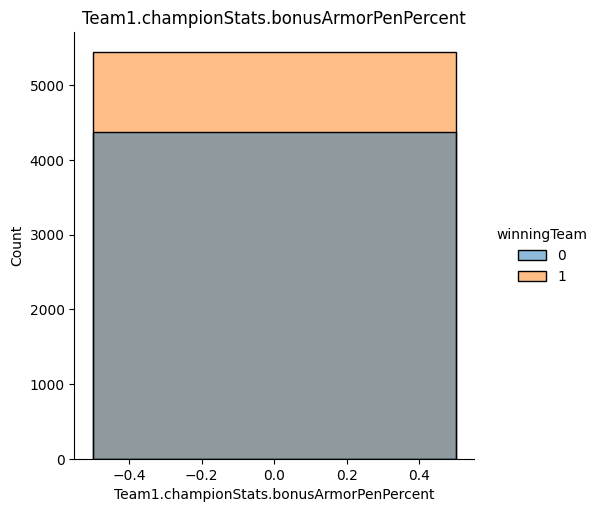

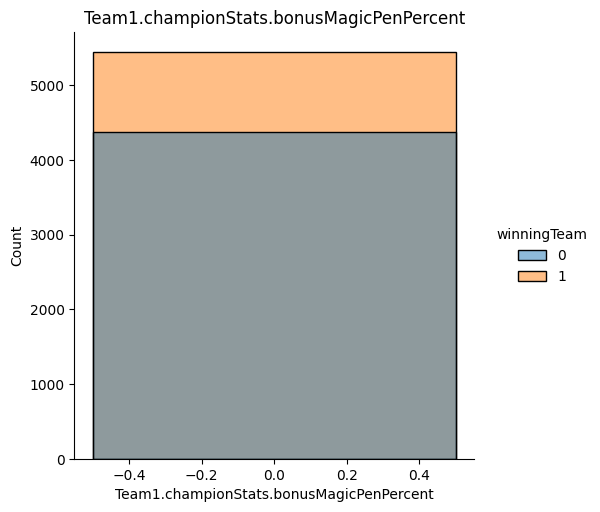

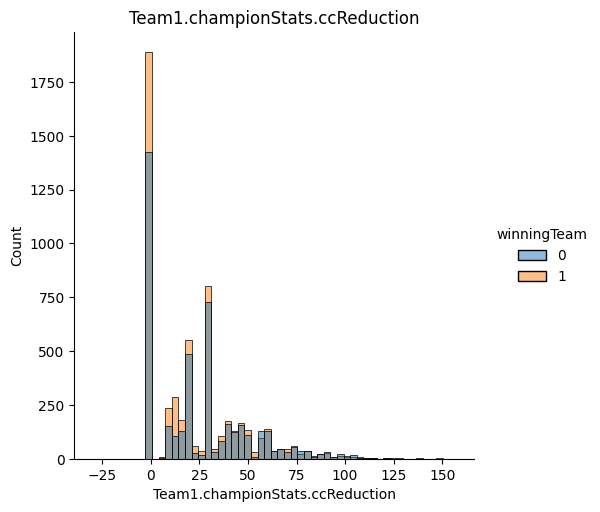

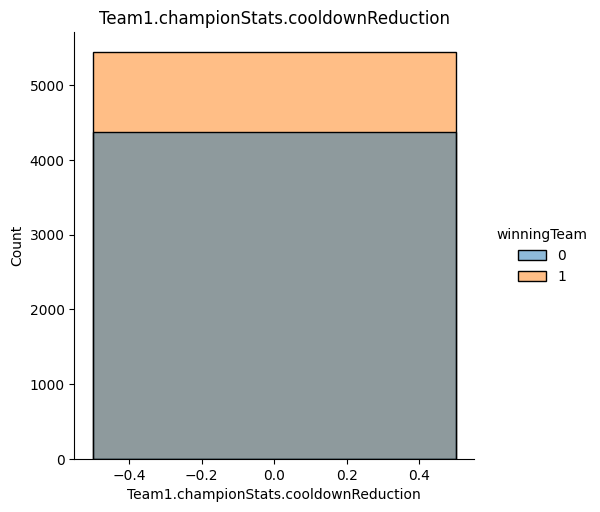

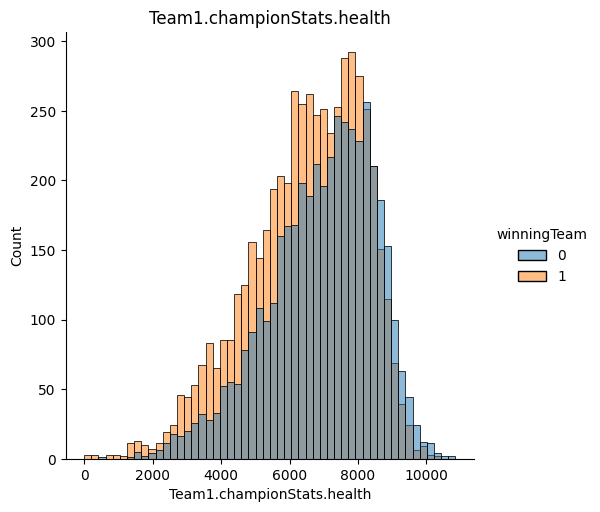

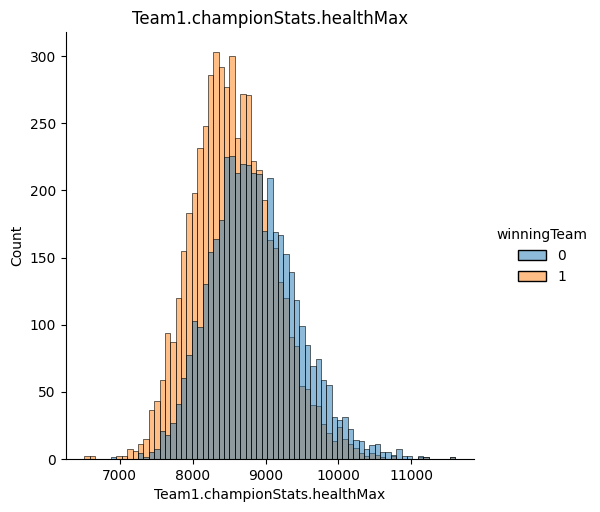

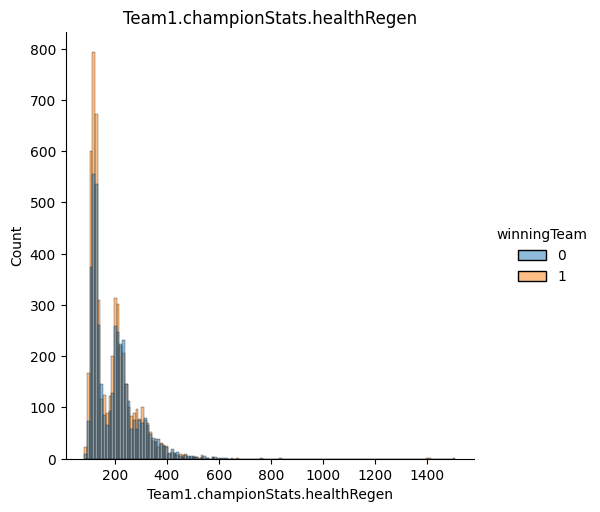

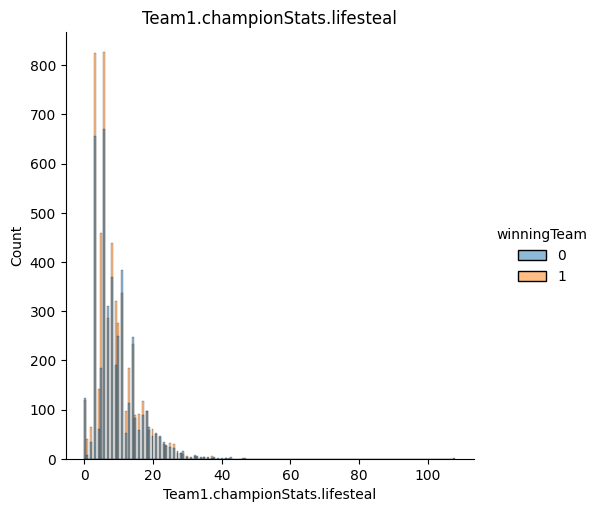

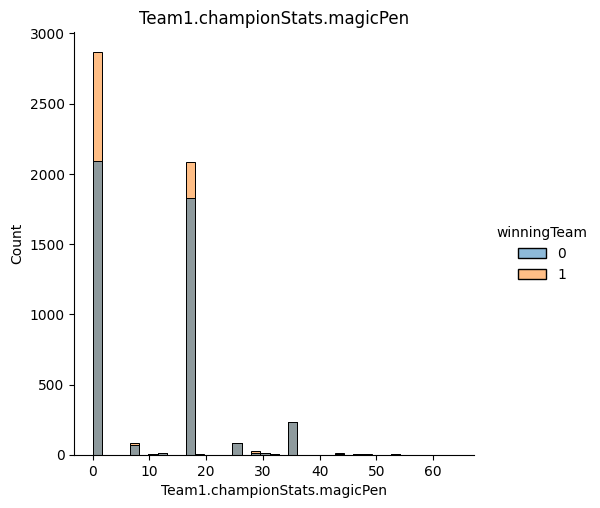

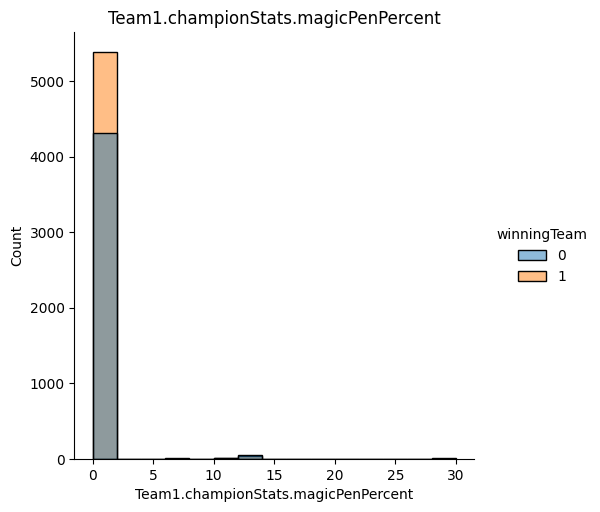

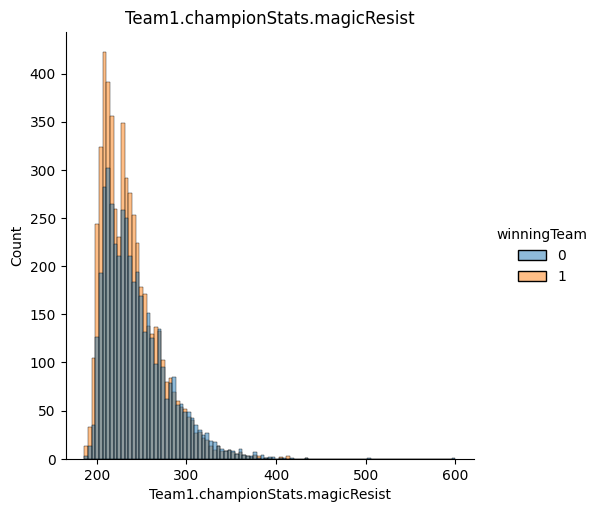

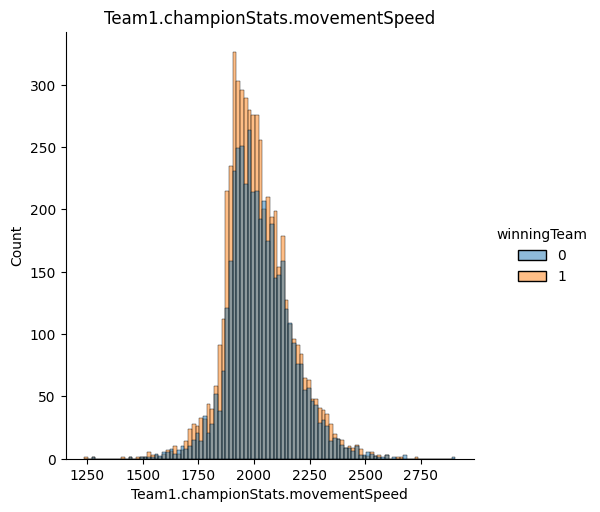

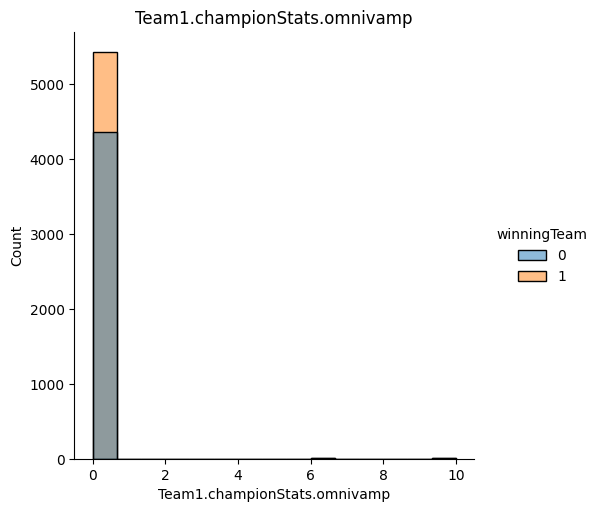

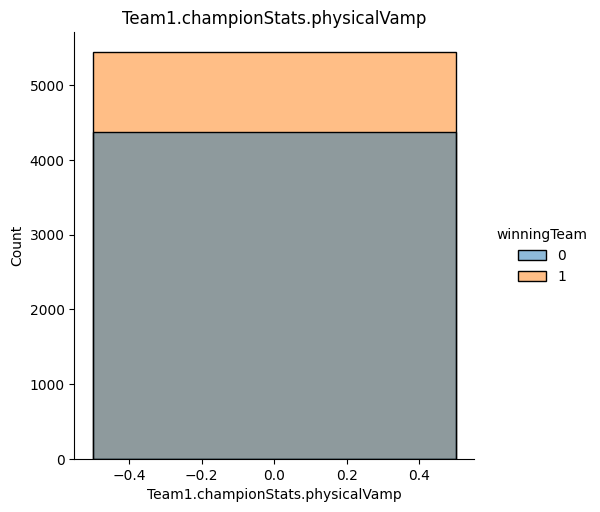

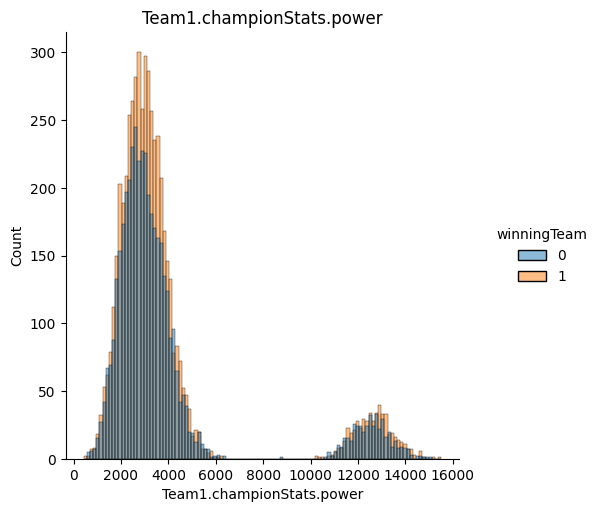

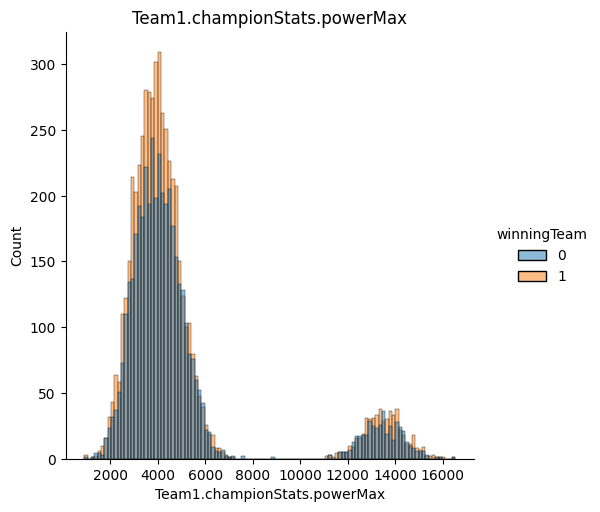

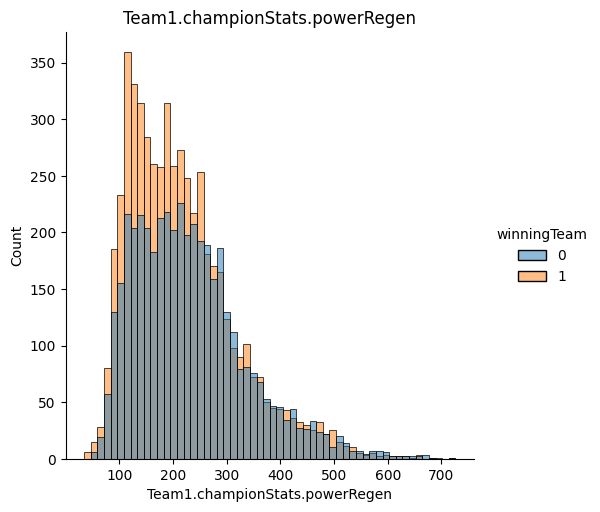

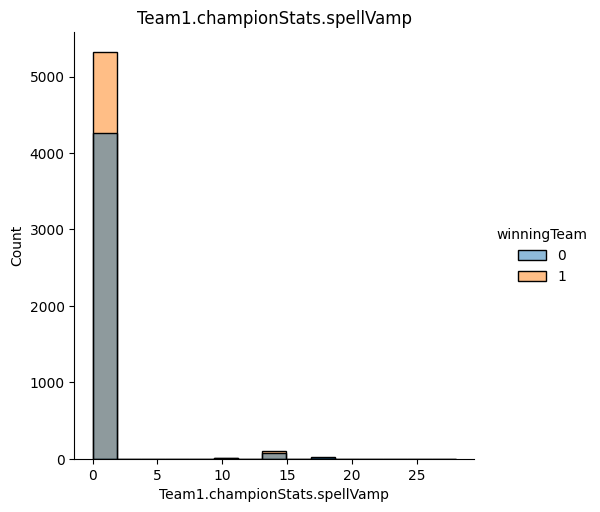

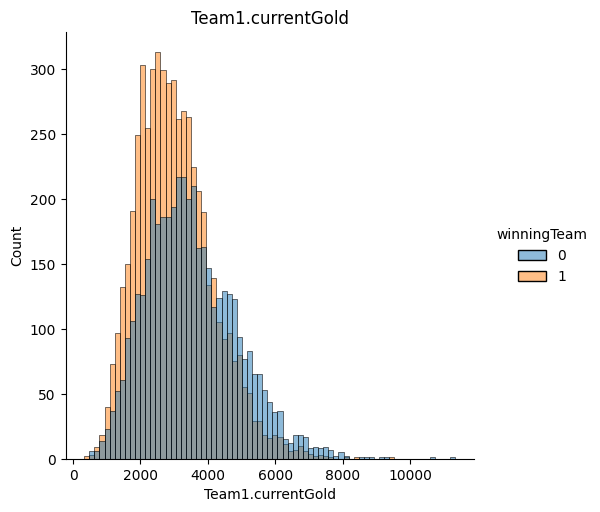

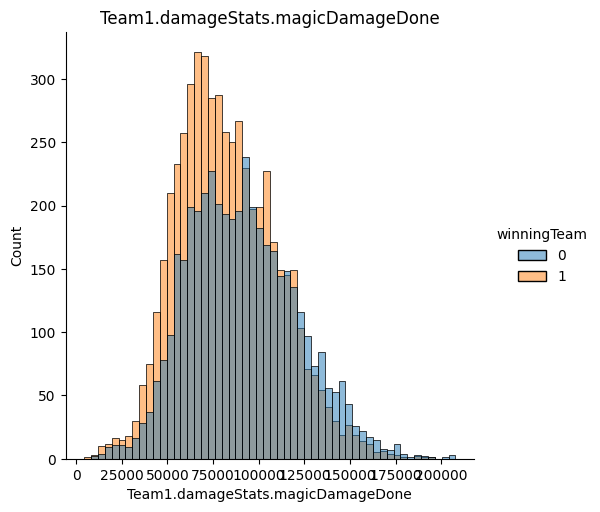

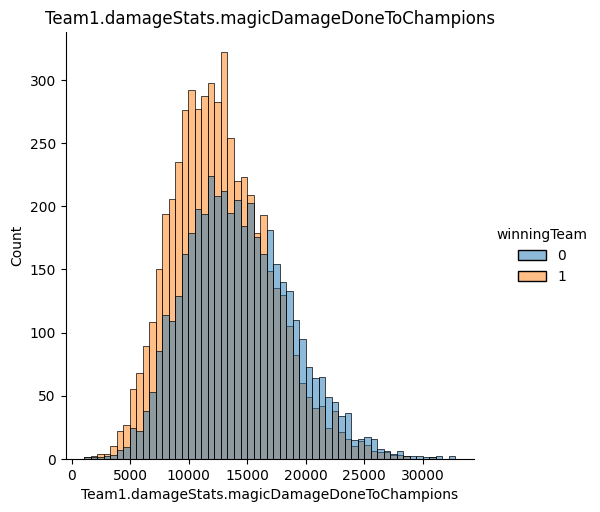

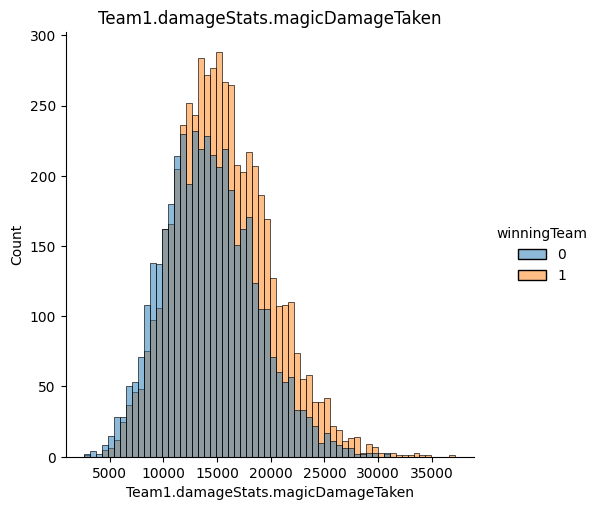

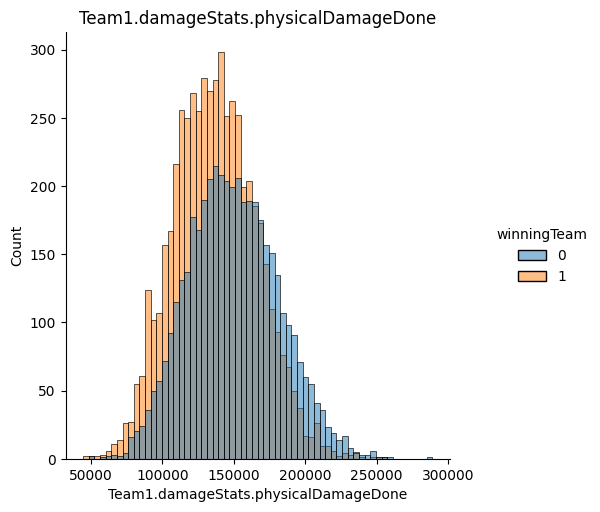

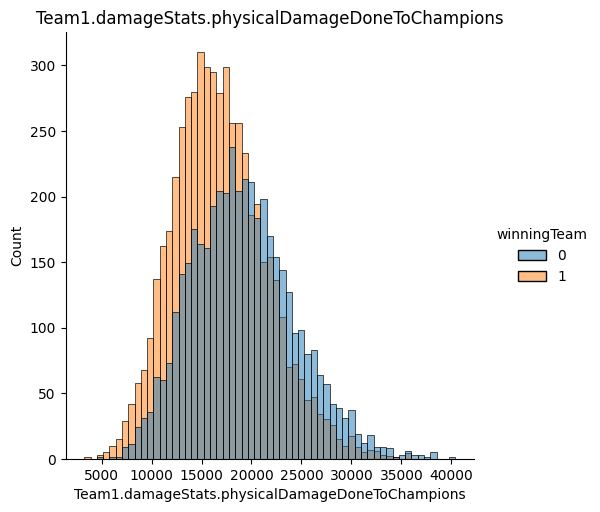

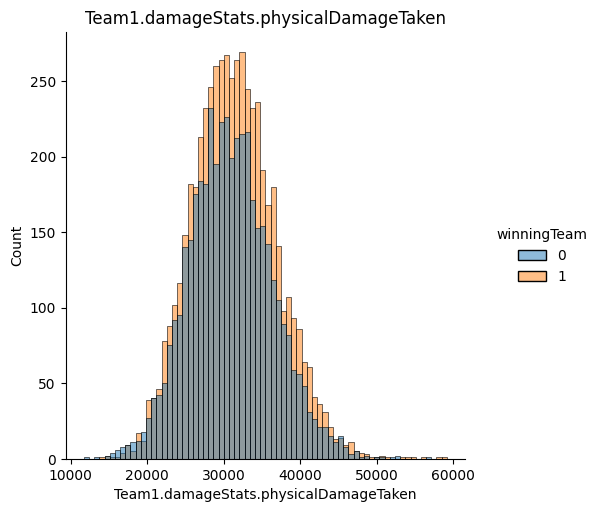

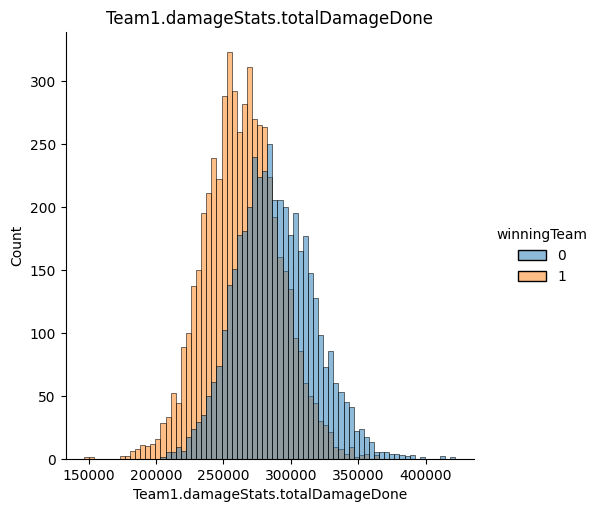

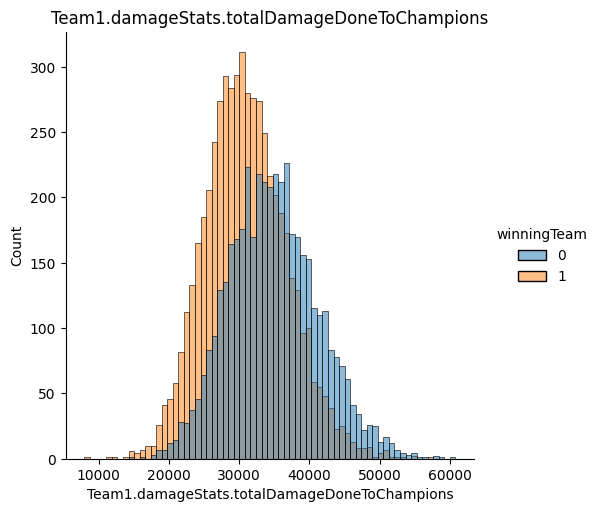

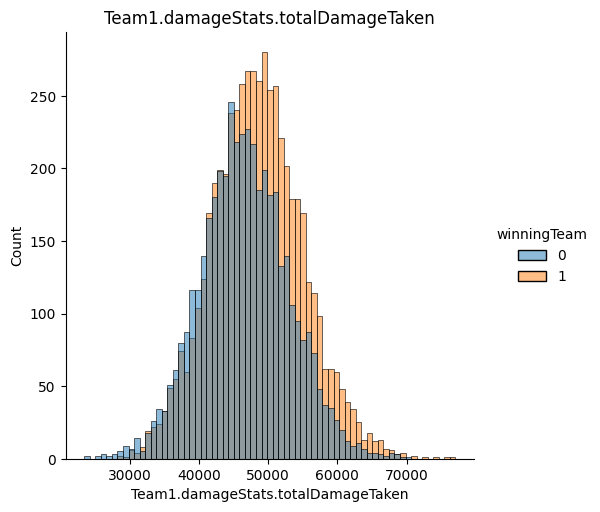

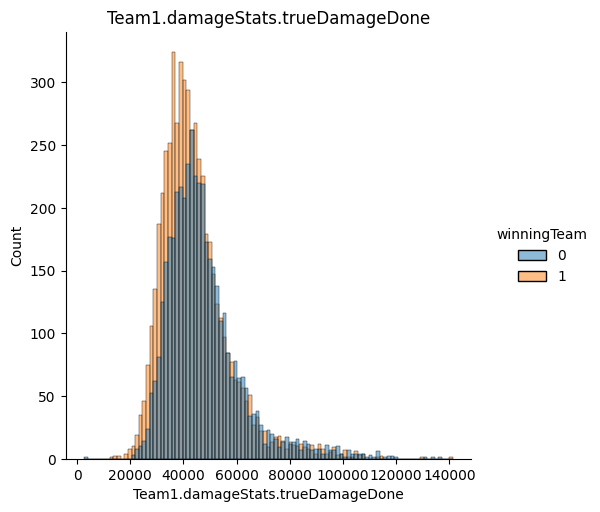

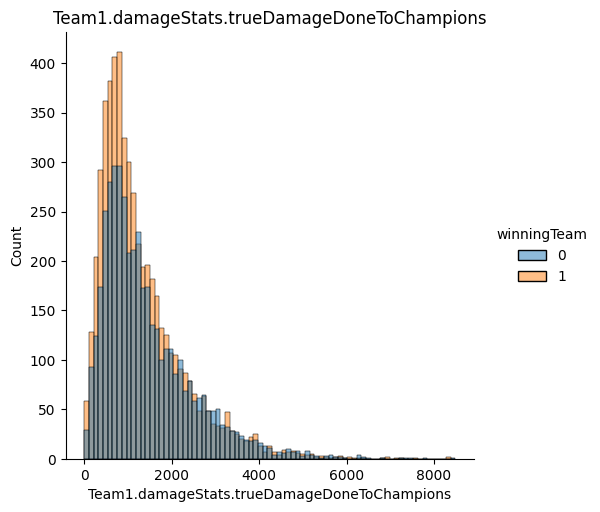

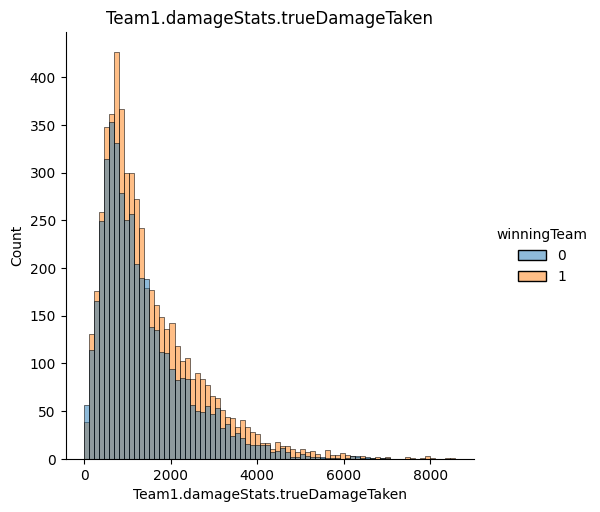

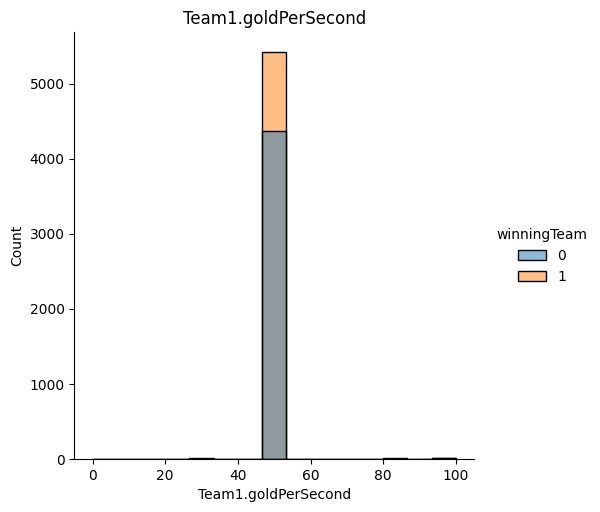

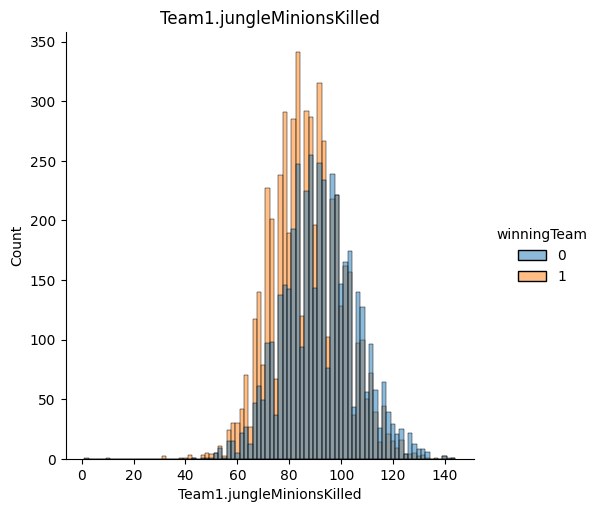

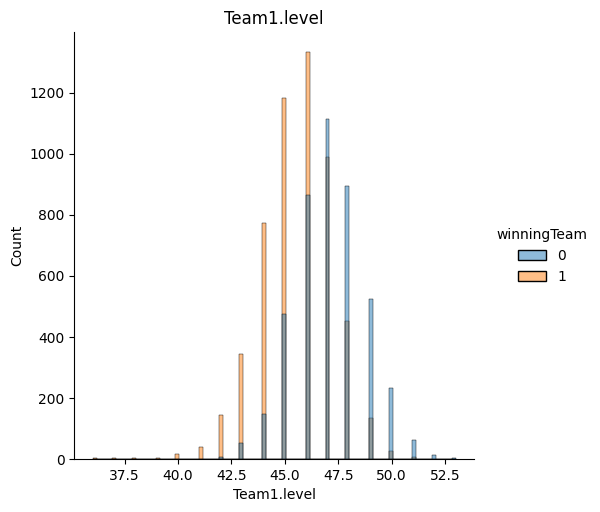

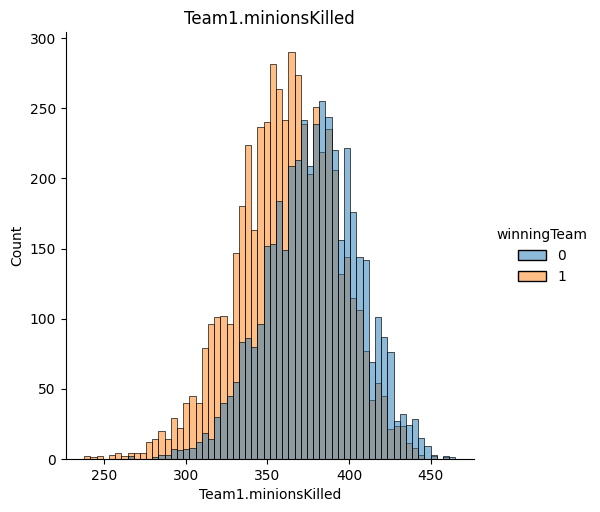

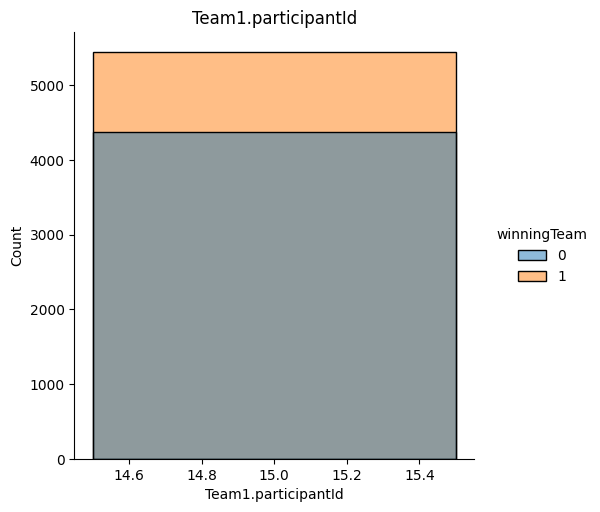

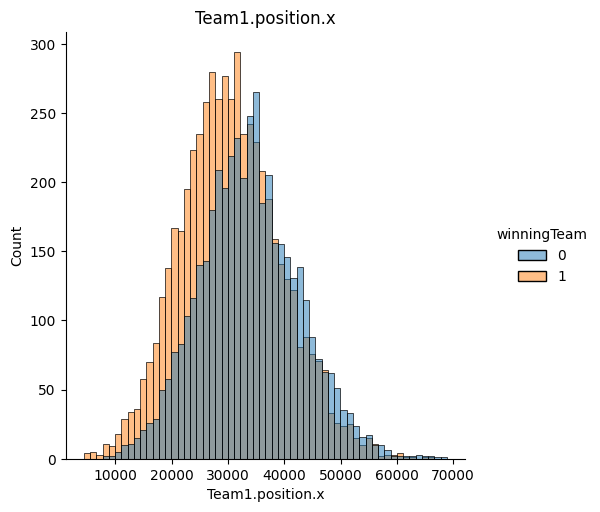

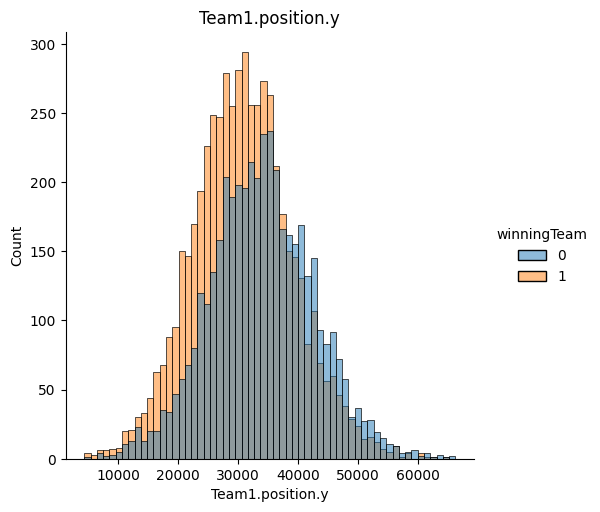

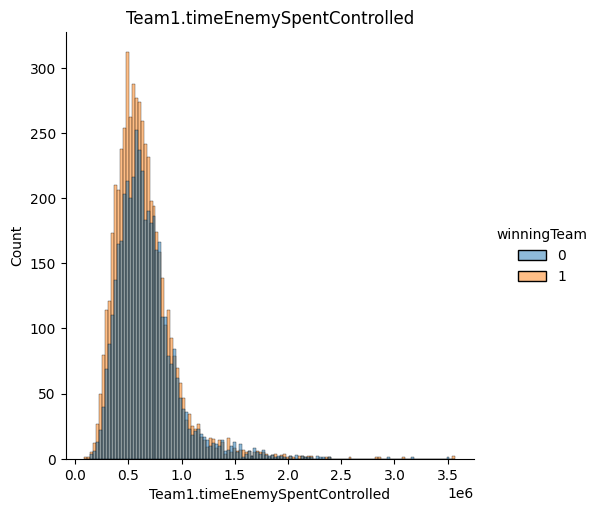

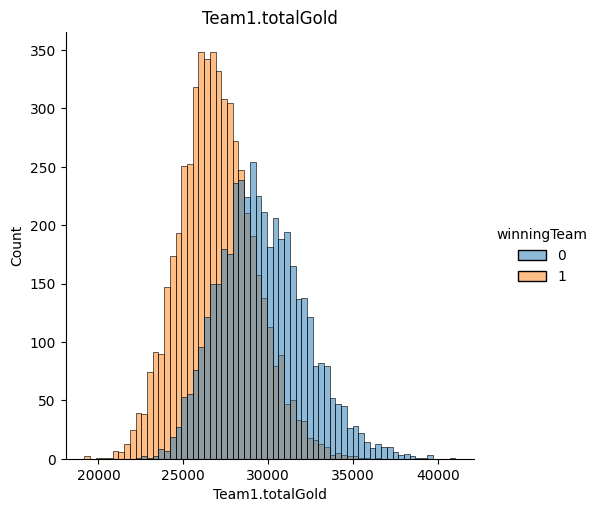

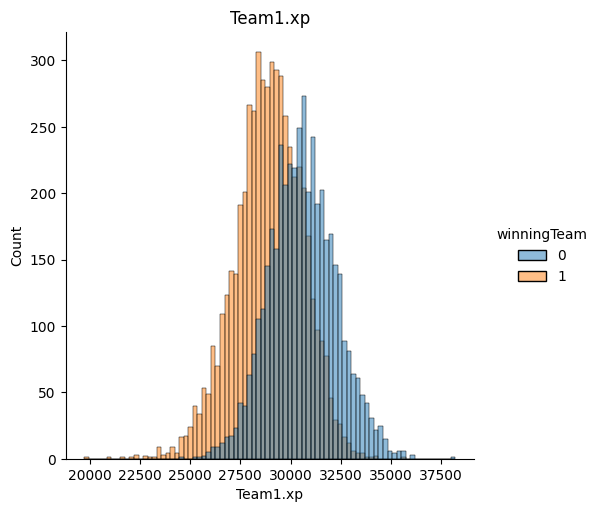

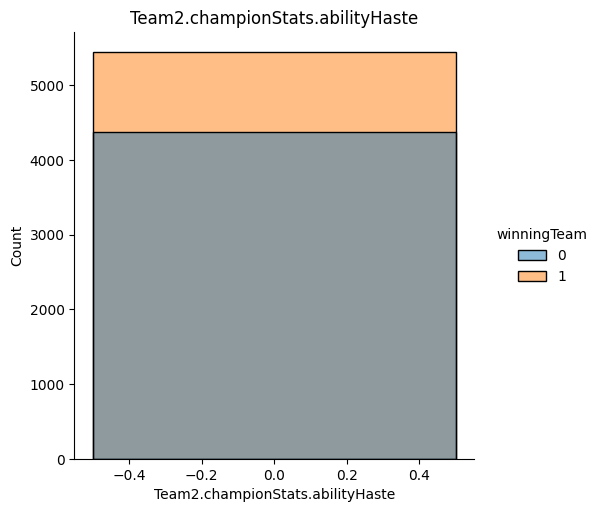

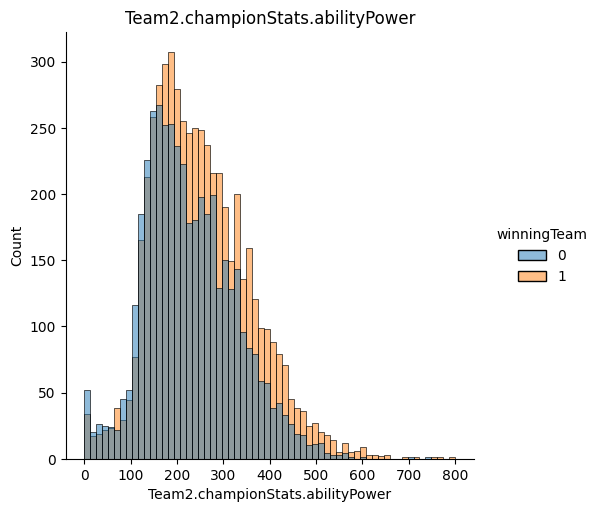

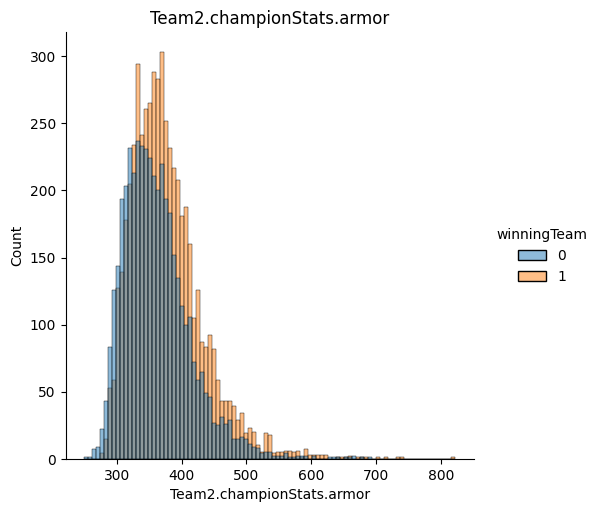

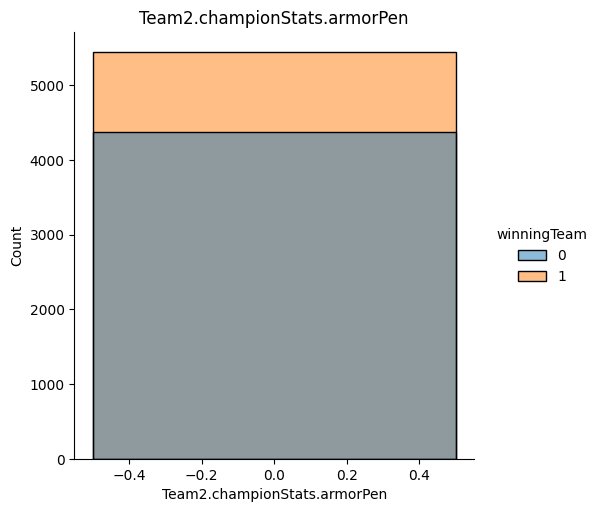

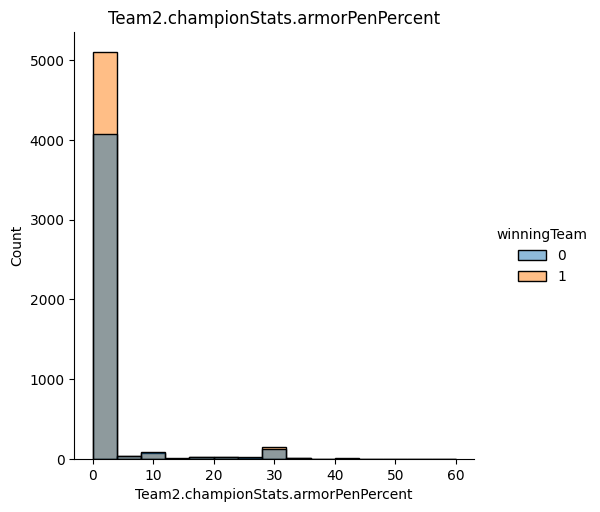

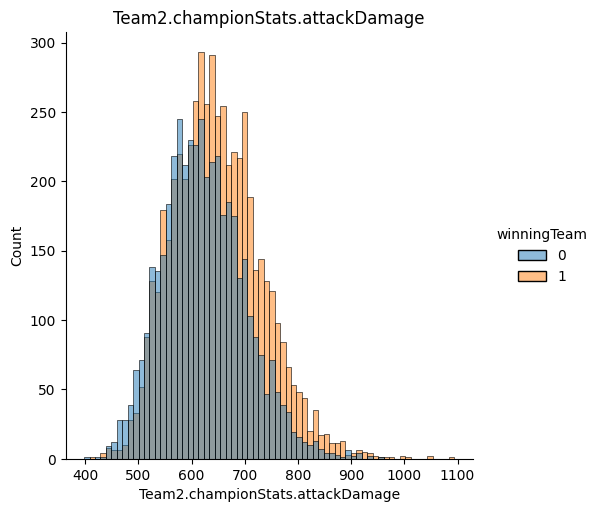

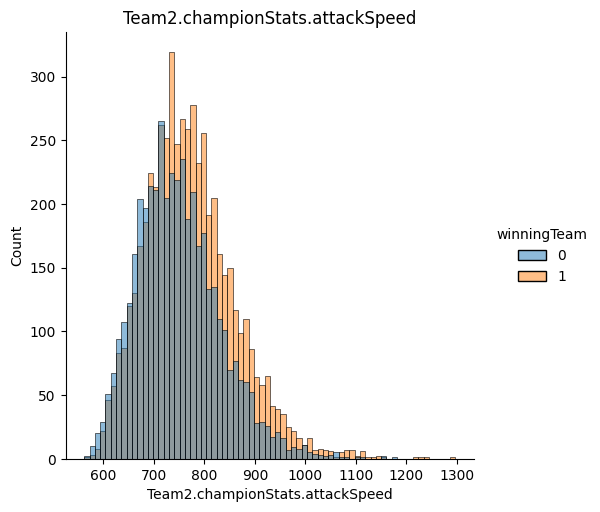

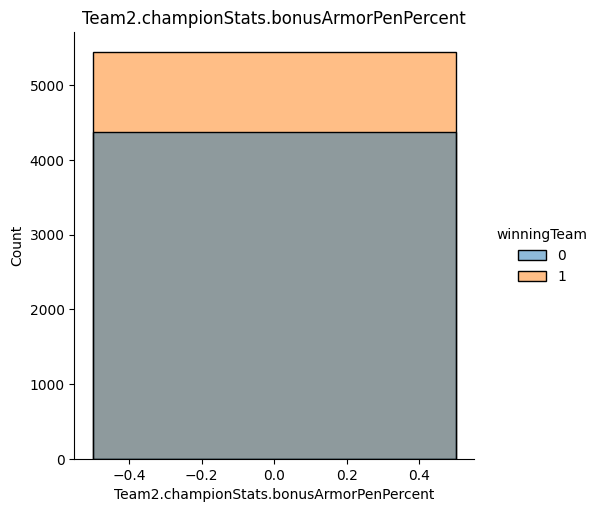

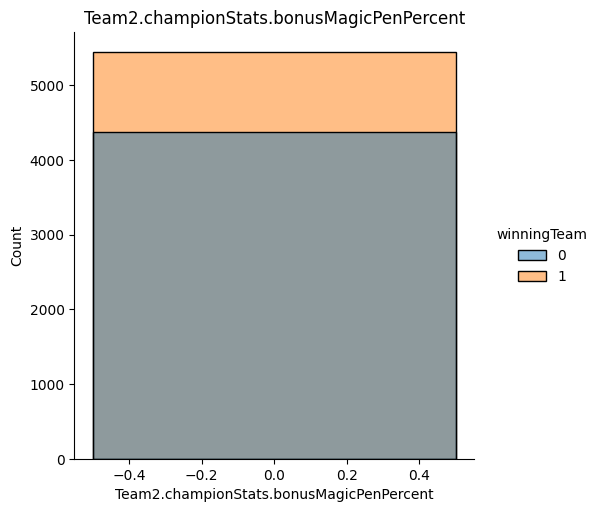

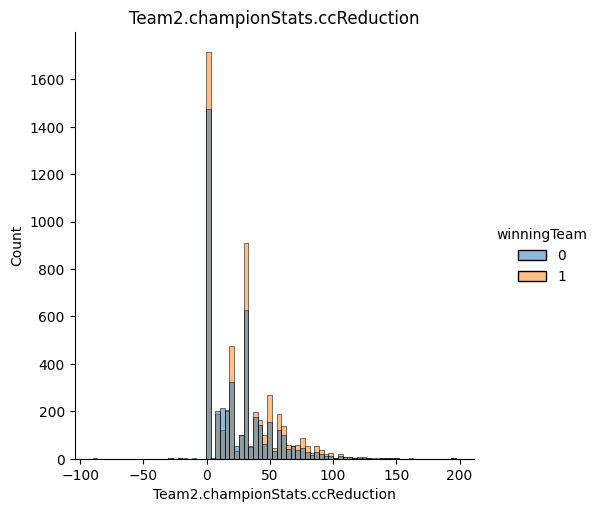

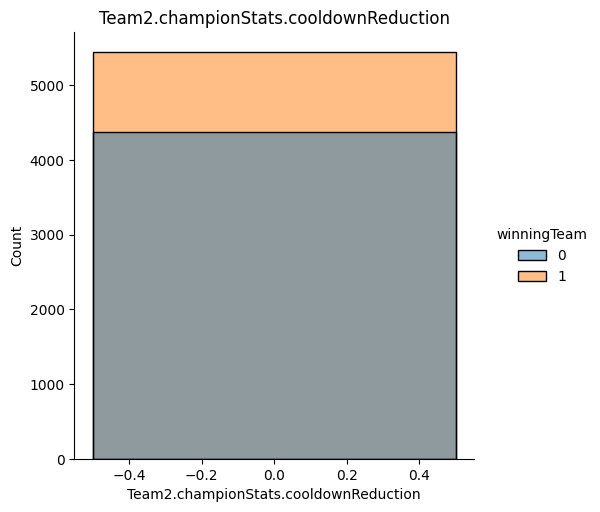

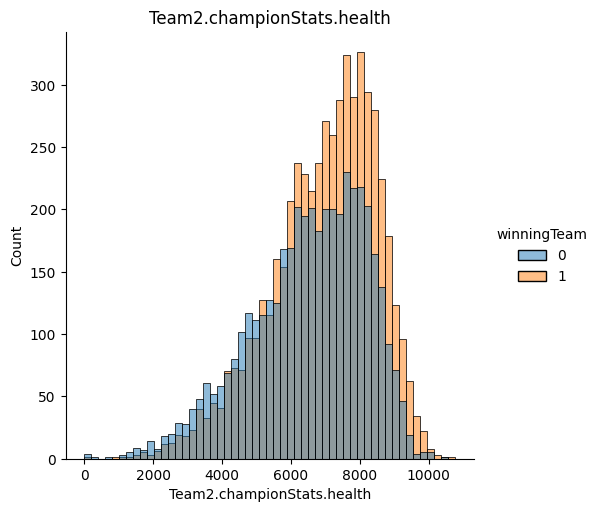

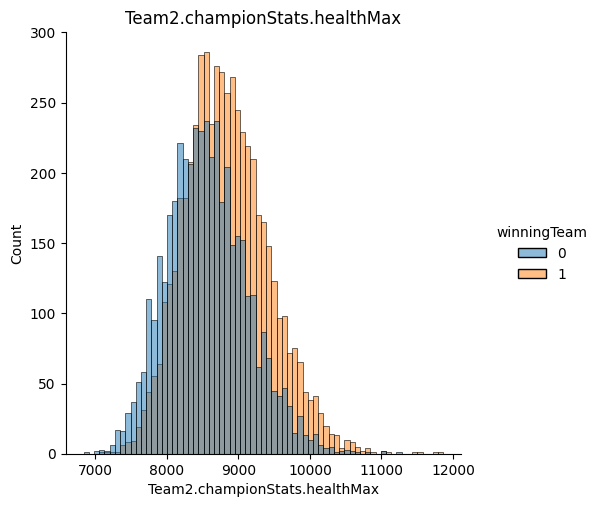

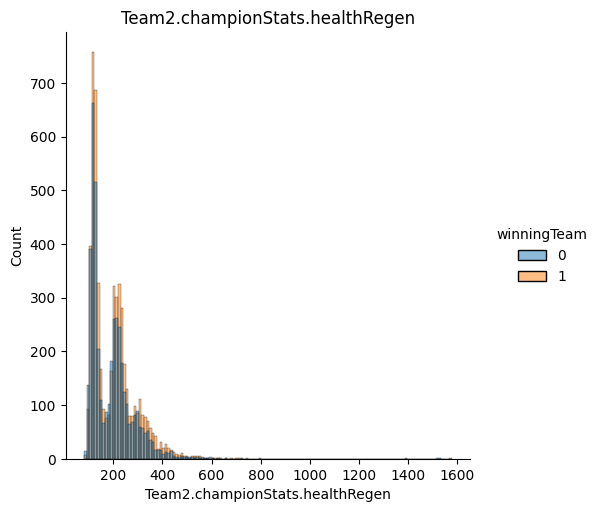

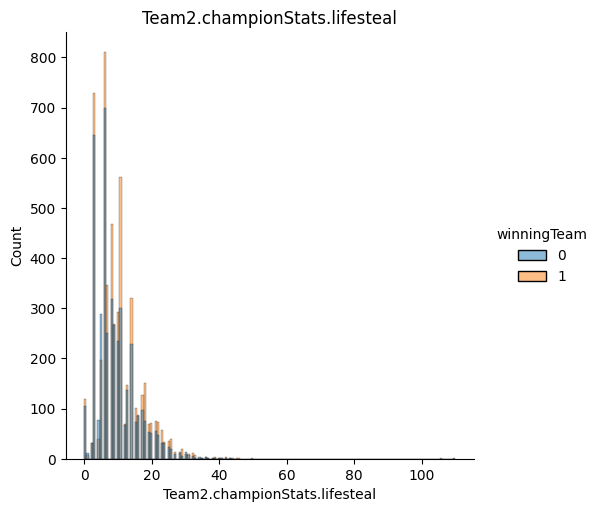

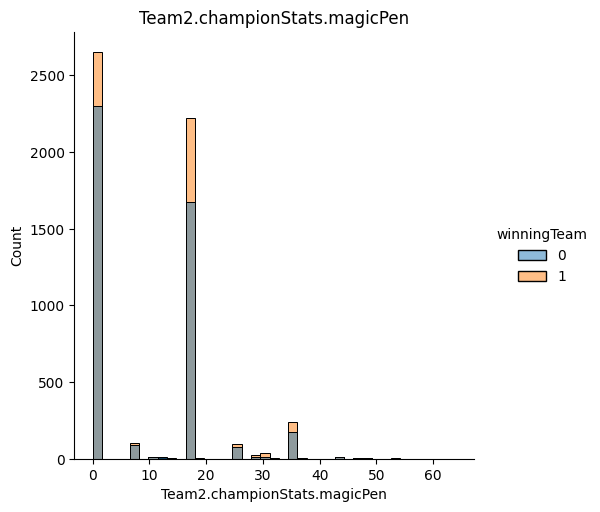

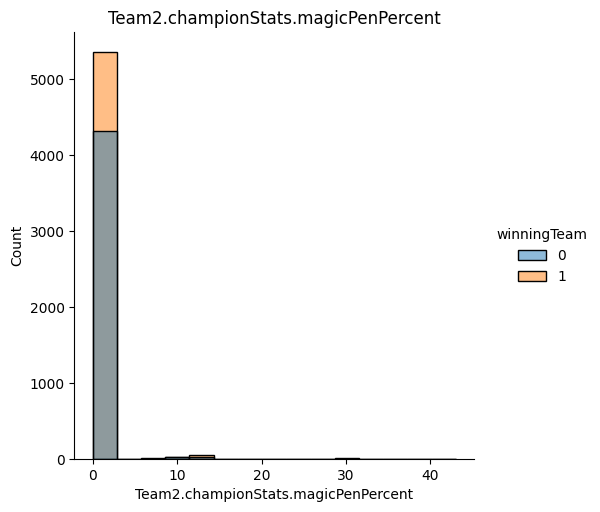

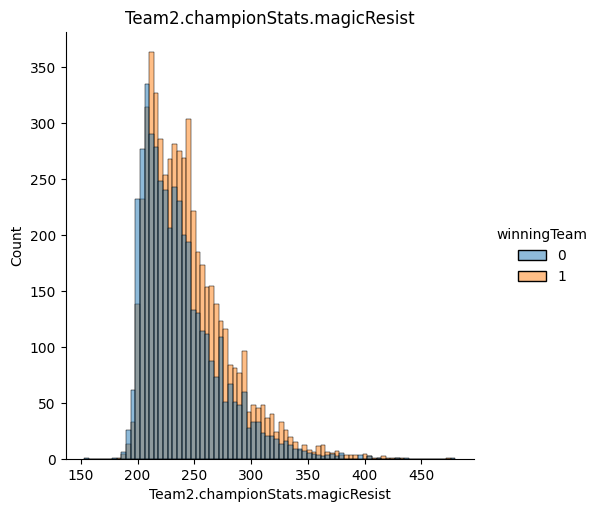

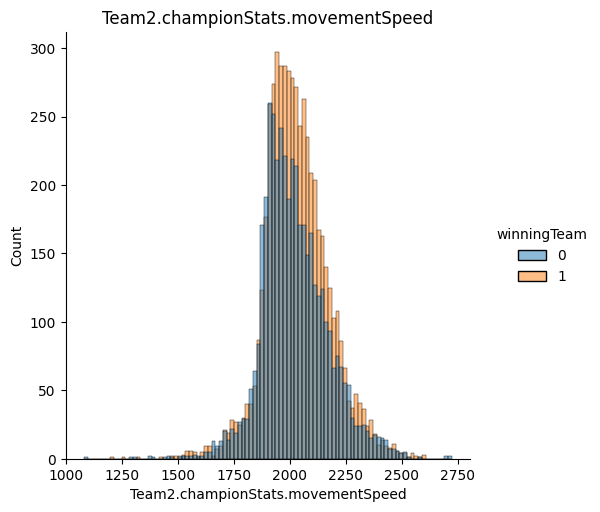

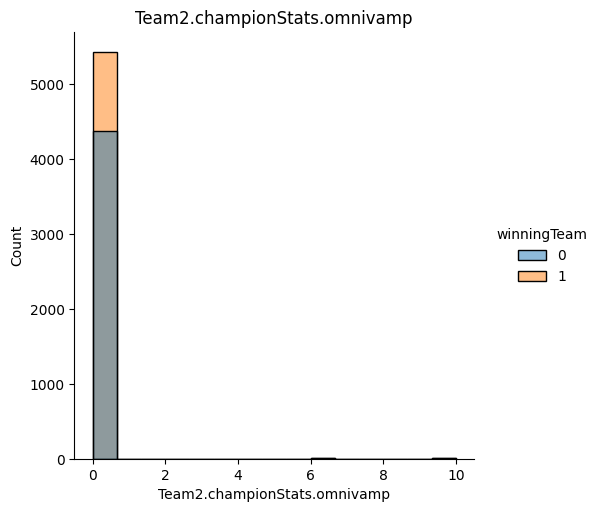

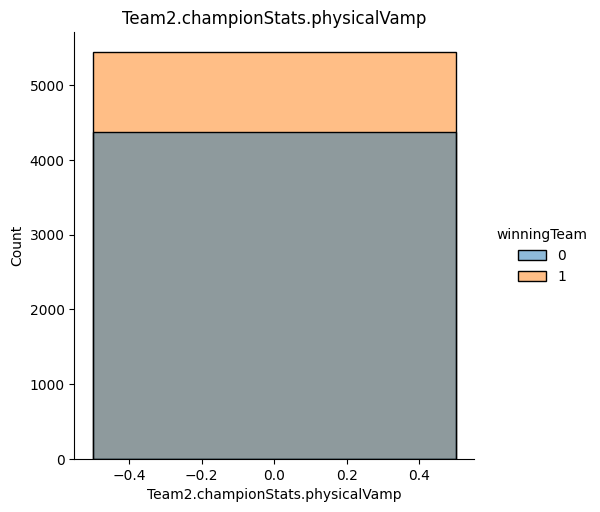

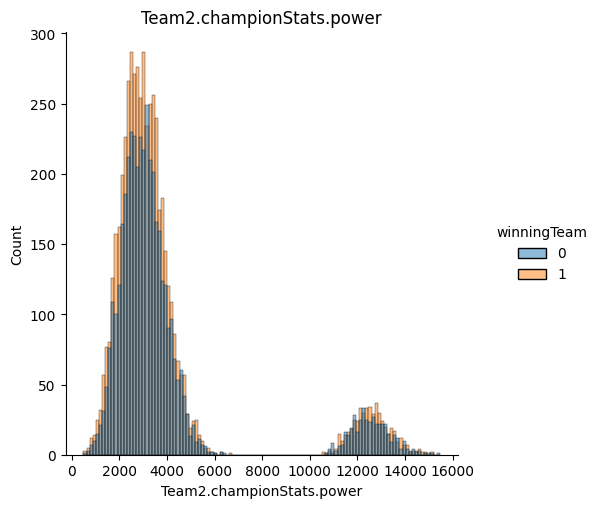

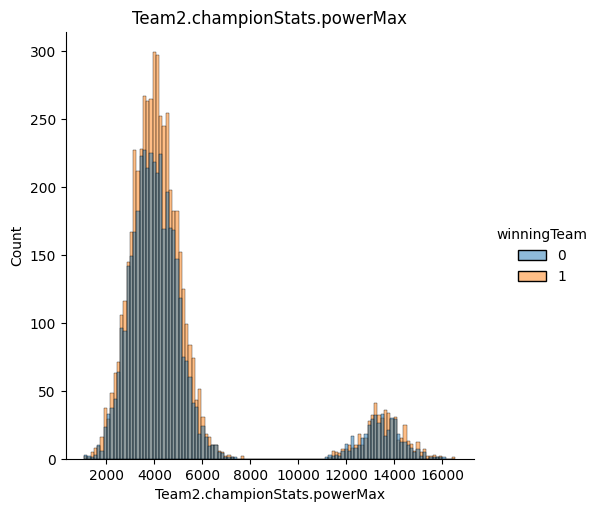

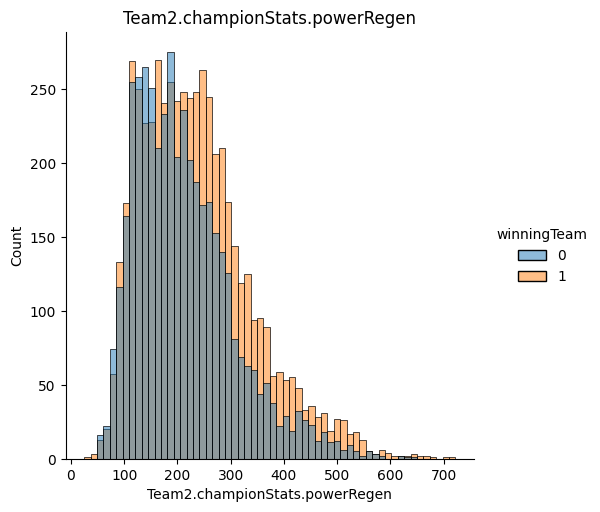

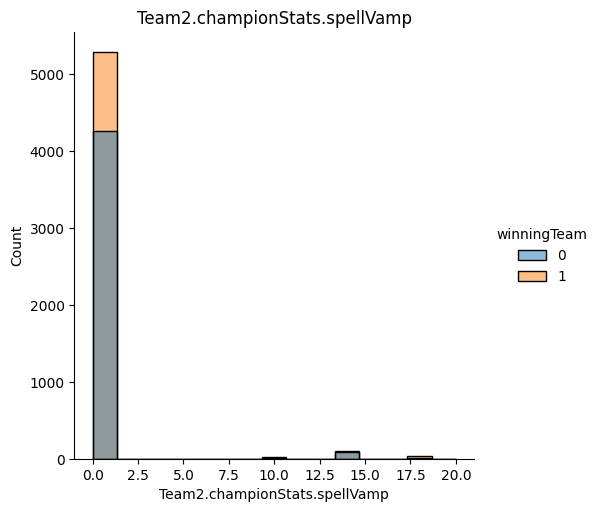

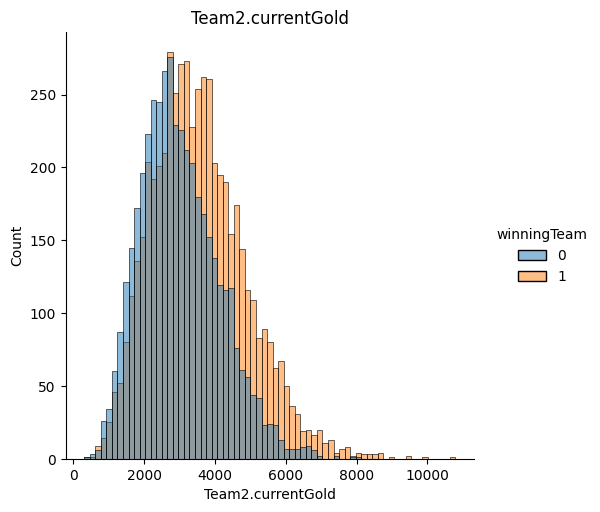

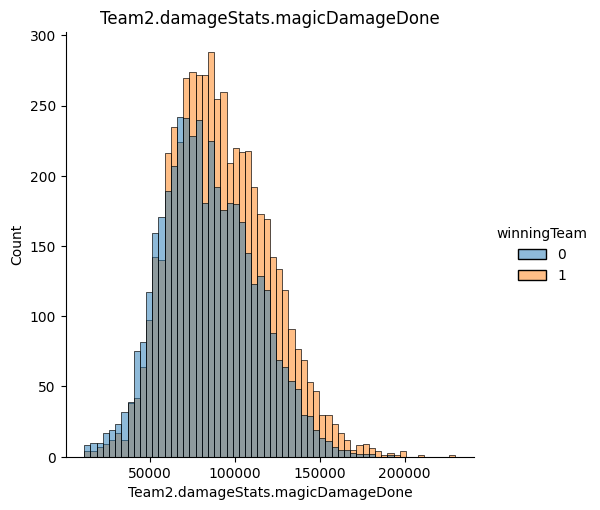

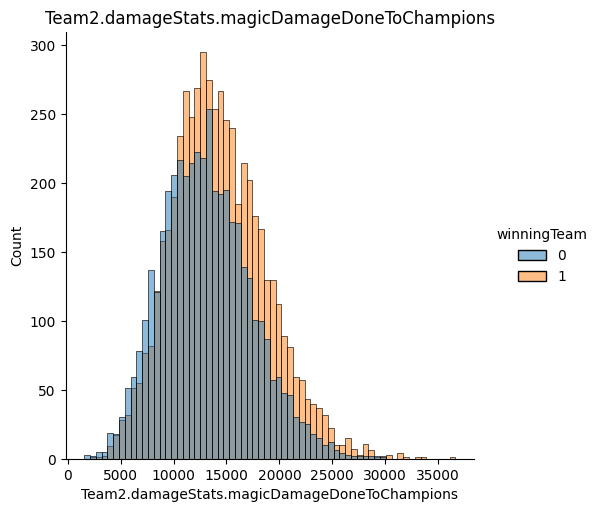

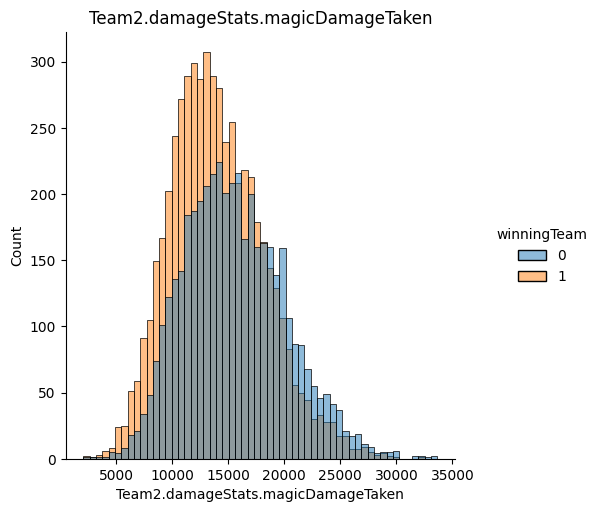

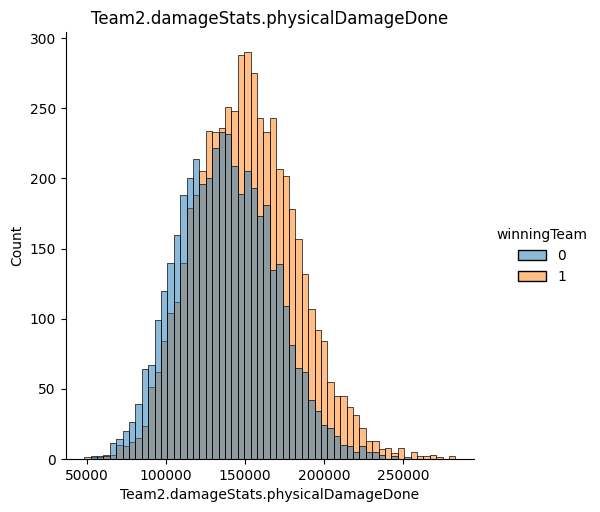

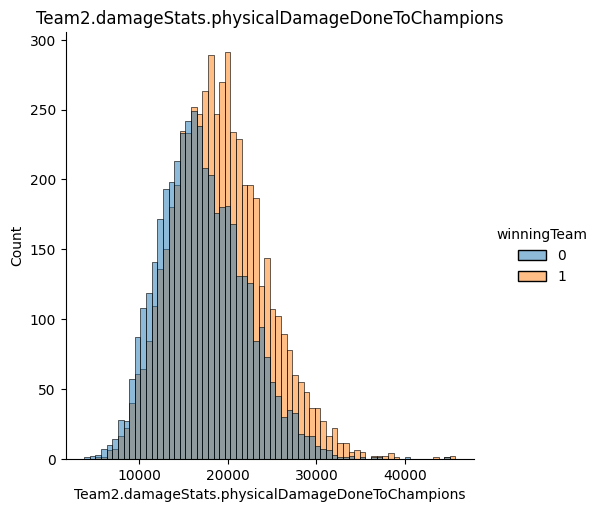

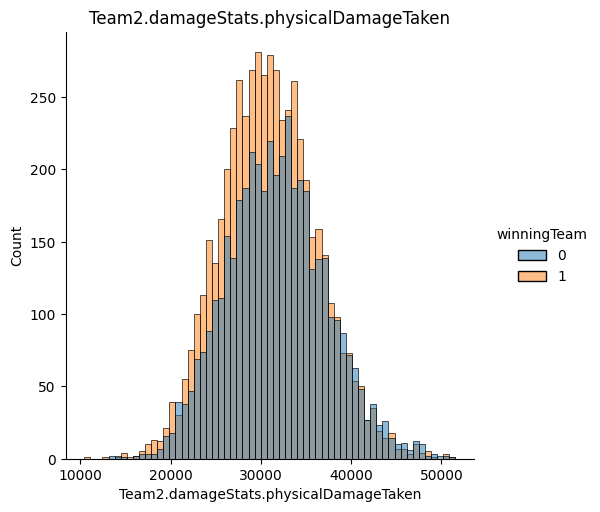

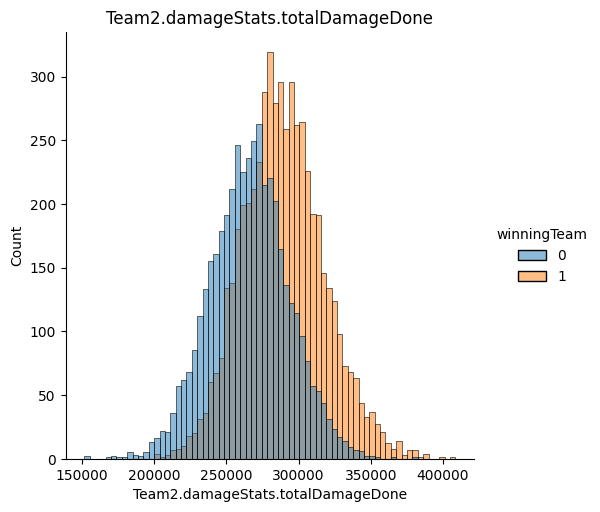

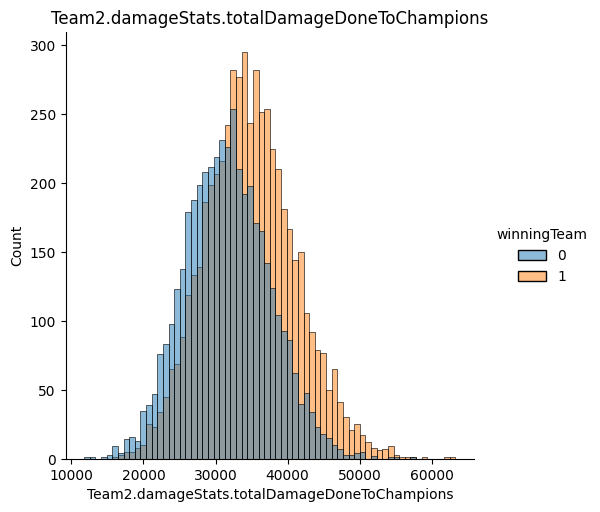

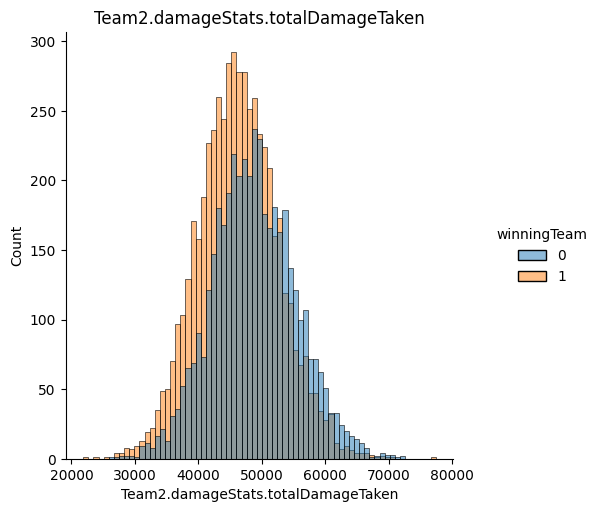

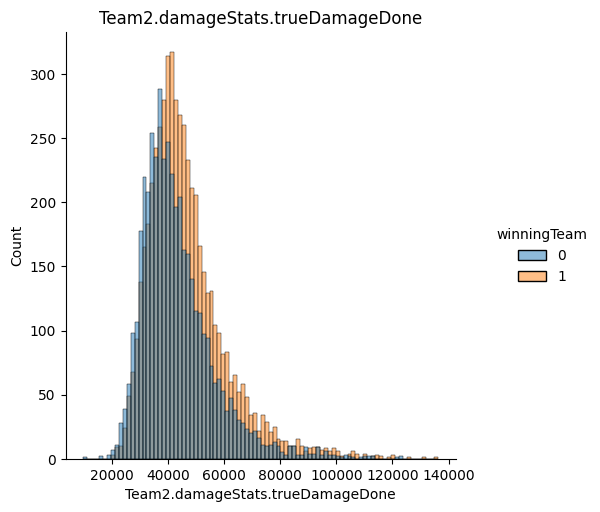

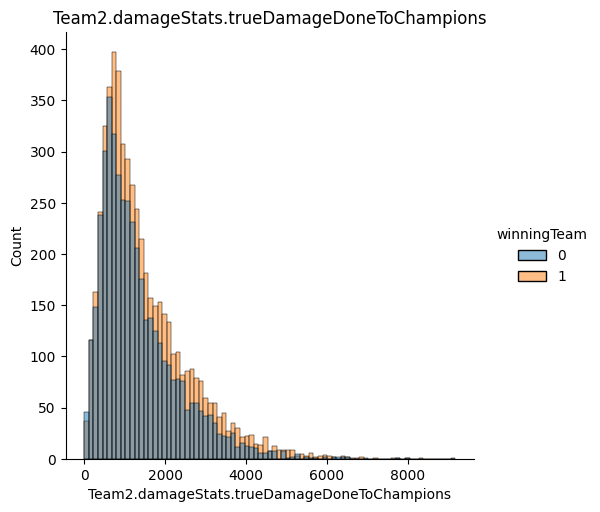

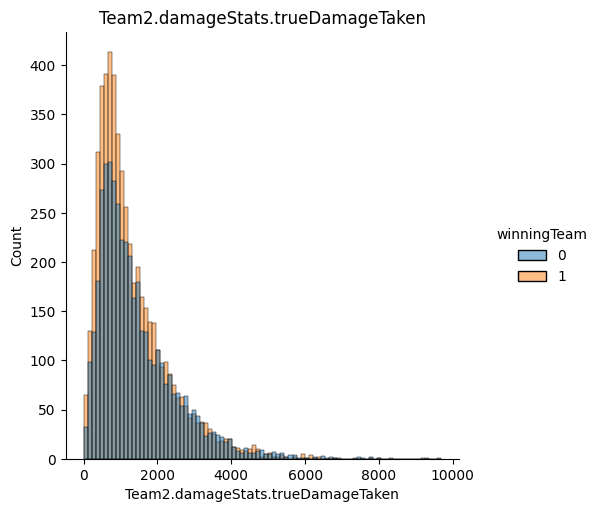

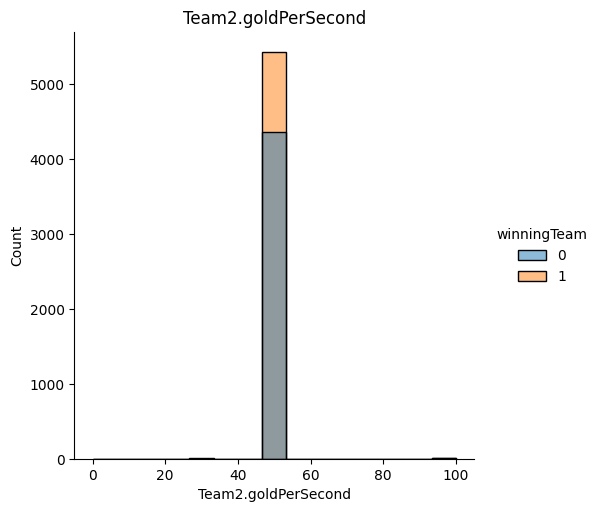

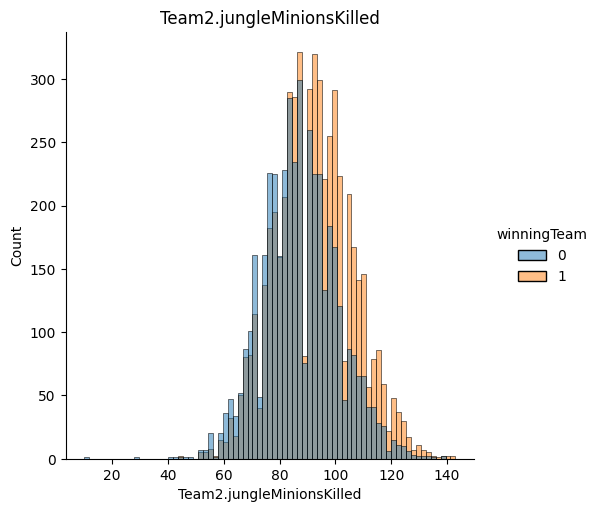

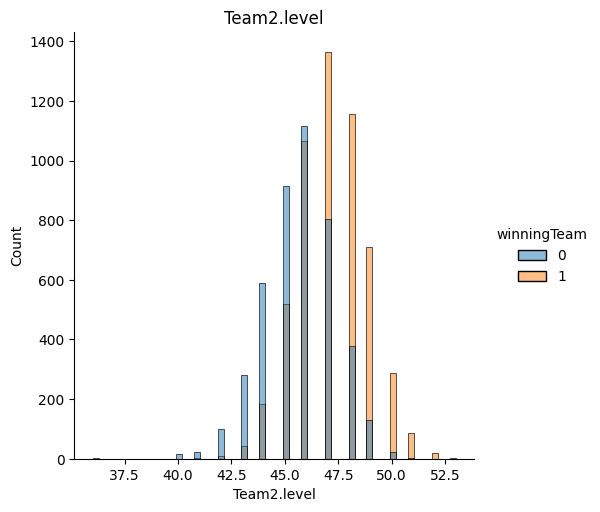

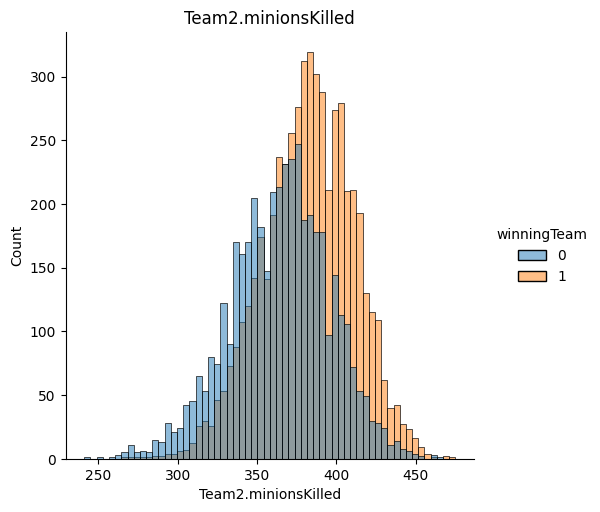

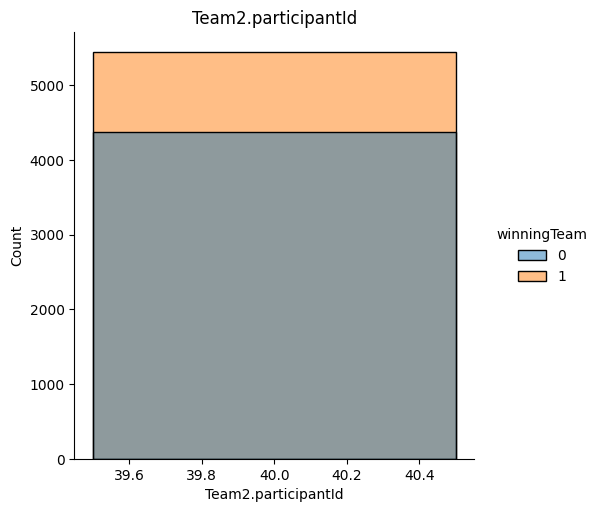

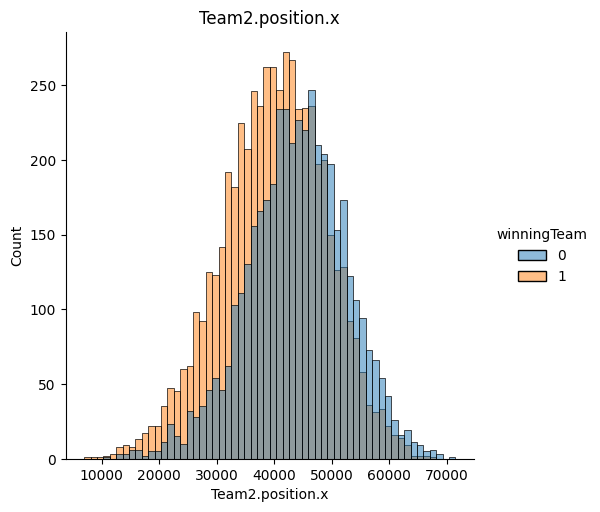

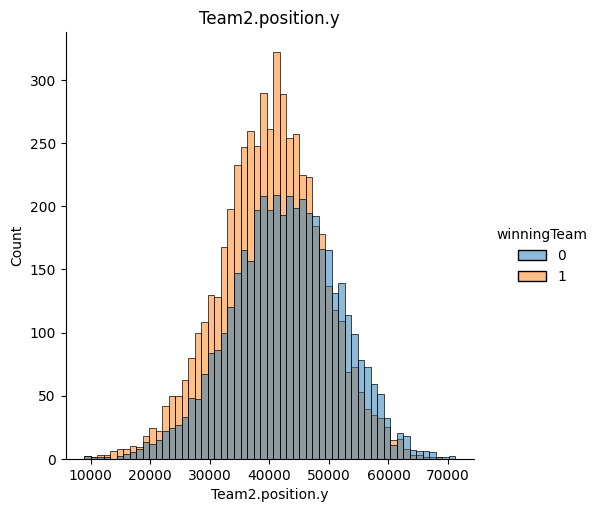

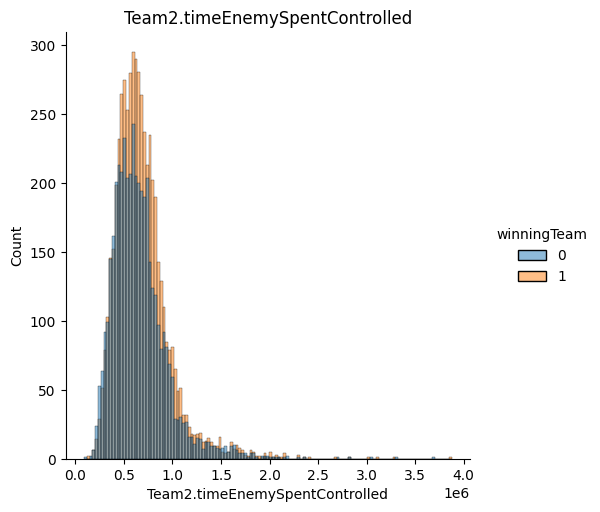

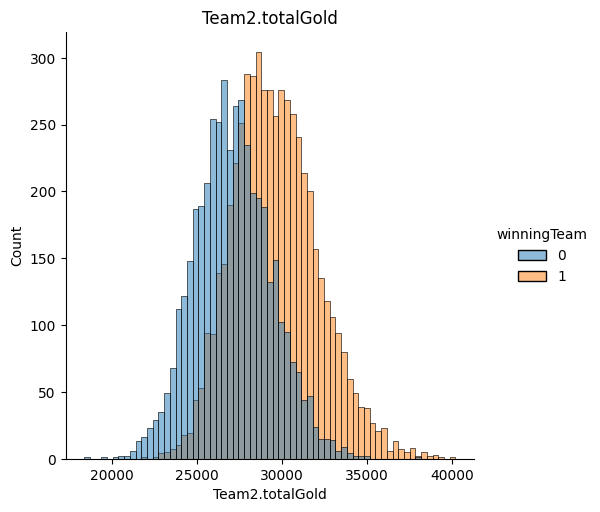

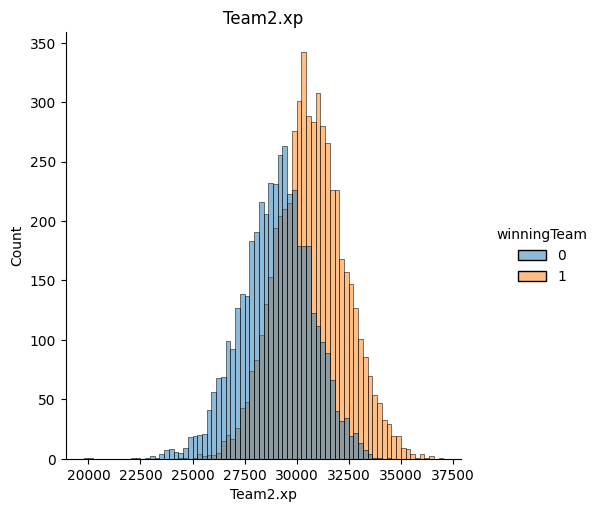

In [11]:
#We take the first half of the dataset to display variables distribution with seaborn
#display the distribution of the variables
def display_distributions(data):
    data = shuffle(data)
    for column in data.columns:
        if column != 'winningTeam':
            sns.displot(data, x=column, hue='winningTeam')
            plt.title(column)
            plt.show()

display_distributions(data)

In [11]:
to_remove = ['Team1.championStats.armorPen','Team1.championStats.abilityHaste', 'Team1.championStats.armorPenPercent', 'Team1.championStats.bonusArmorPenPercent', 'Team1.championStats.bonusMagicPenPercent', 'Team1.championStats.cooldownReduction', 'Team1.championStats.physicalVamp', 'Team1.participantId', 'Team2.championStats.armorPen', 'Team2.championStats.abilityHaste', 'Team2.championStats.armorPenPercent', 'Team2.championStats.bonusArmorPenPercent', 'Team2.championStats.bonusMagicPenPercent', 'Team2.championStats.cooldownReduction', 'Team2.championStats.physicalVamp', 'Team2.participantId']
shape1 = data.shape
print("Shape before deleting useless columns : ", data.shape)

data = data.drop(columns=to_remove, errors='ignore')
shape2 = data.shape

if shape1 == shape2:
    print("No columns were deleted")
else :
    print("Shape after deleting useless columns : ", data.shape)


Shape before deleting useless columns :  (9818, 97)
Shape after deleting useless columns :  (9818, 81)


In [12]:
data.describe()

winningTeam  Team1.championStats.abilityPower  \
count  9818.000000                       9818.000000   
mean      0.553982                        235.988389   
std       0.497103                        102.364094   
min       0.000000                          0.000000   
25%       0.000000                        161.000000   
50%       1.000000                        222.000000   
75%       1.000000                        299.000000   
max       1.000000                        776.000000   

       Team1.championStats.armor  Team1.championStats.attackDamage  \
count                9818.000000                       9818.000000   
mean                  367.605419                        633.077205   
std                    51.235050                         80.809331   
min                   263.000000                        410.000000   
25%                   331.000000                        575.000000   
50%                   360.000000                        628.000000   
75%                   395.000000                        683.000000   
max                   726.000000                       1092.000000   

       Team1.championStats.attackSpeed  Team1.championStats.ccReduction  \
count                      9818.000000                      9818.000000   
mean                        750.664799                        23.865349   
std                          85.775827                        24.537527   
min                         512.000000                       -30.000000   
25%                         690.000000                         0.000000   
50%                         740.000000                        19.000000   
75%                         799.000000                        37.000000   
max                        1283.000000                       157.000000   

       Team1.championStats.health  Team1.championStats.healthMax  \
count                 9818.000000                    9818.000000   
mean                  6677.439906                    8685.072214   
std                   1626.682522                     594.400115   
min                      0.000000                    6511.000000   
25%                   5674.000000                    8270.000000   
50%                   6882.000000                    8646.000000   
75%                   7922.000000                    9063.750000   
max                  10846.000000                   11605.000000   

       Team1.championStats.healthRegen  Team1.championStats.lifesteal  ...  \
count                       9818.00000                    9818.000000  ...   
mean                         191.54288                       9.105826  ...   
std                           87.66935                       6.186328  ...   
min                           82.00000                       0.000000  ...   
25%                          122.00000                       5.000000  ...   
50%                          169.00000                       8.000000  ...   
75%                          234.00000                      11.000000  ...   
max                         1510.00000                     108.000000  ...   

       Team2.damageStats.trueDamageTaken  Team2.goldPerSecond  \
count                        9818.000000          9818.000000   
mean                         1369.947138            50.113058   
std                          1036.203035             2.596306   
min                             0.000000             0.000000   
25%                           646.000000            50.000000   
50%                          1070.000000            50.000000   
75%                          1823.000000            50.000000   
max                          9687.000000           100.000000   

       Team2.jungleMinionsKilled  Team2.level  Team2.minionsKilled  \
count                9818.000000  9818.000000          9818.000000   
mean                   90.010084    46.502852           374.196781   
std                    13.956451     1.798736            31.125968   
min          

In [14]:
def plot_custom_graph(title, data_sample, col , xlabel, ylabel):
    plt.figure(figsize=(10,6))
    plt.title(title)
    plt.scatter(data_sample["Team1."+col], data_sample["Team2."+col], c=data_sample["winningTeam"], cmap='coolwarm')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.legend(['Blue team wins', 'Red team wins']) 
    plt.show()


# Graphs

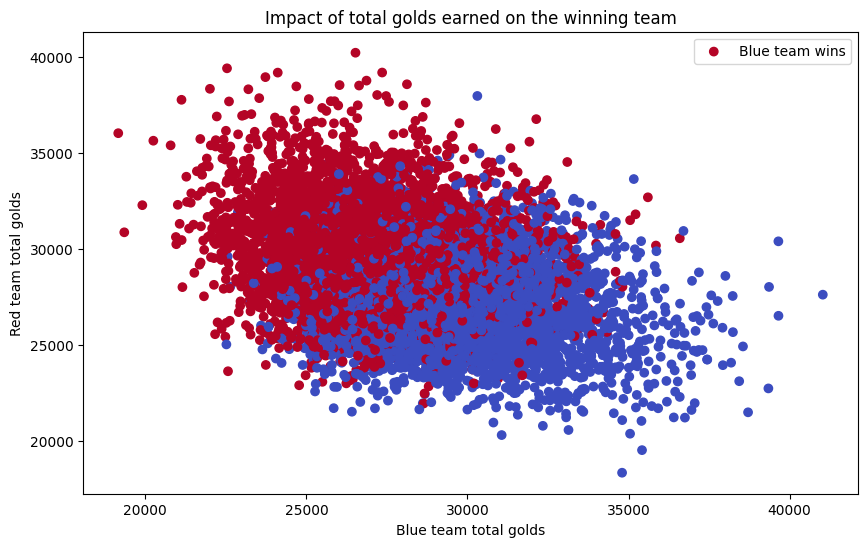

In [15]:
#Impact of total golds earned on the winning team
plot_custom_graph('Impact of total golds earned on the winning team', data, 'totalGold', 'Blue team total golds', 'Red team total golds')

League of legends is game heavily influenced by golds as this graph shows.

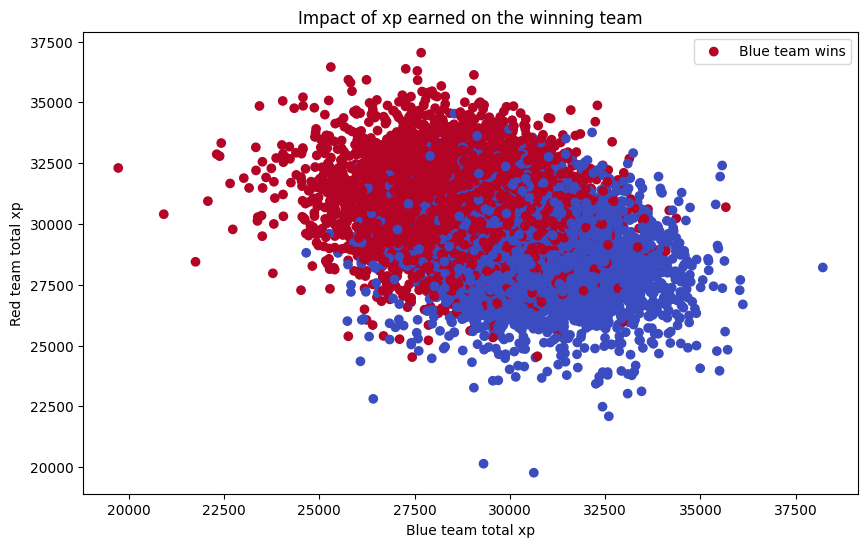

In [16]:
#Impact of total xp earned on the winning team
plot_custom_graph('Impact of xp earned on the winning team', data, 'xp', 'Blue team total xp', 'Red team total xp')

It seems that the experience points earned is important 

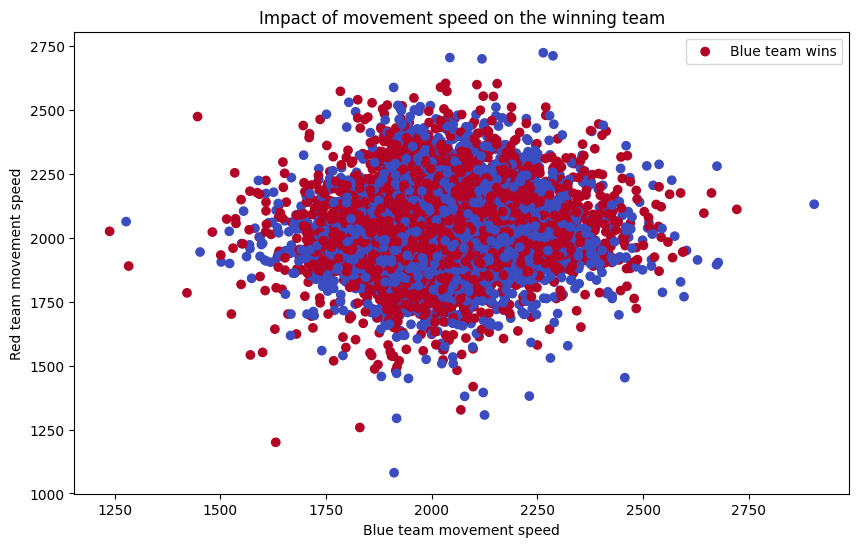

In [17]:
plot_custom_graph('Impact of movement speed on the winning team', data, 'championStats.movementSpeed', 'Blue team movement speed', 'Red team movement speed')

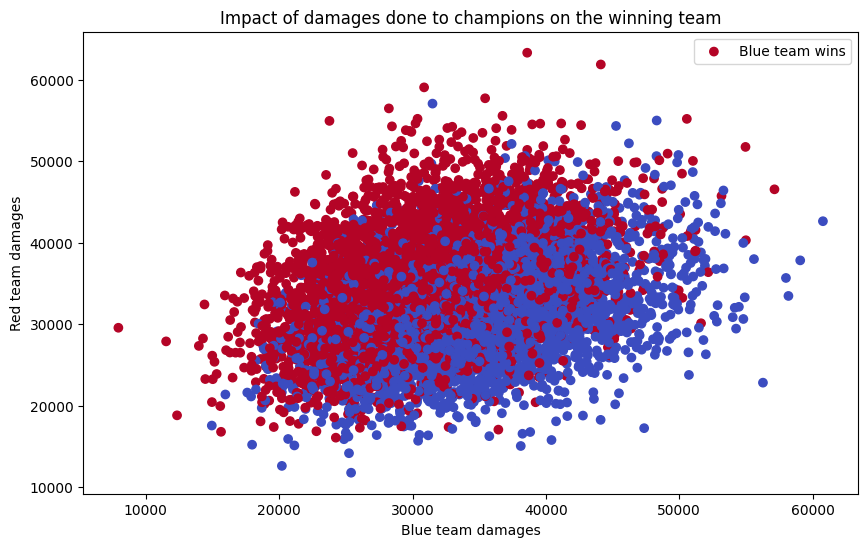

In [18]:
plot_custom_graph('Impact of damages done to champions on the winning team', data, 'damageStats.totalDamageDoneToChampions', 'Blue team damages', 'Red team damages')

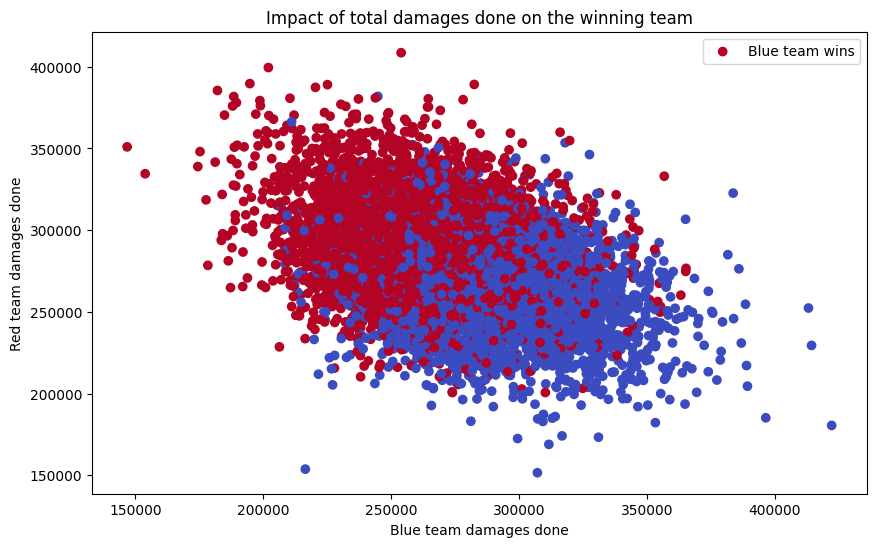

In [19]:
plot_custom_graph('Impact of total damages done on the winning team', data, 'damageStats.totalDamageDone', 'Blue team damages done', 'Red team damages done')

# Jalon 2

Nous voulons faire une régression logistique pénalisée.

Ce choix se justifie car nous cherchons à prédire une variable qualitative binaire.

Pour les hyperparamètres, nous allons utiliser une gridSearchCV pour selectionner les meilleurs hyperparamètres.

Ceux-ci sont:

    -la pénalité

    -l'inverse de la force de régularisation, C

    -le nombre d'itérations maximal

    -le ratio entre l1 et l2 pour l'elasticNet

Nous n'utilisons pas un randomSearch pour les hyperparamètres car il n'y a pas tant de valeurs à tester.

Pour ajuster nos hyperparamètres, nous utilisons plusieurs cross-validations:

    -Une, en interne, pour la sélection des hyperparamètres

    -Une, en externe, pour l'évaluation de la généralisation de notre modèle

On compare donc par cross-validation la geénéralisation de plusieurs hyperparamètres, eux-meme sélectionnés par cross-validation.

Pour cela, on a séparé nos données plusieurs fois en train, validation et test set.

In [20]:
data

winningTeam  Team1.championStats.abilityPower  \
0               1                               177   
1               1                               185   
2               1                               186   
3               0                               195   
4               1                               230   
...           ...                               ...   
9813            1                               334   
9814            1                               225   
9815            0                               456   
9816            1                               188   
9817            0                               288   

      Team1.championStats.armor  Team1.championStats.attackDamage  \
0                           352                               628   
1                           446                               551   
2                           466                               603   
3                           307                               746   
4                           348                               759   
...                         ...                               ...   
9813                        307                               867   
9814                        362                               664   
9815                        380                               817   
9816                        393                               651   
9817                        419                               520   

      Team1.championStats.attackSpeed  Team1.championStats.ccReduction  \
0                                 817                               71   
1                                 618                                0   
2                                 826                               30   
3                                 945                               30   
4                                 635                               67   
...                               ...                              ...   
9813                              512                               19   
9814                              692                               18   
9815                              818                                0   
9816                              798                               10   
9817                              713                                0   

      Team1.championStats.health  Team1.championStats.healthMax  \
0                           5720                           9110   
1                           8926                           9271   
2                           4766                           9321   
3                           8176                           8655   
4                           7306                           9108   
...                          ...                            ...   
9813                        7778                           8862   
9814                        6074                           8542   
9815                        8987                           9411   
9816                        3944                           9633   
9817                        7113                           8977   

      Team1.championStats.healthRegen  Team1.championStats.lifesteal  ...  \
0                                 145                              5  ...   
1                                 124                              3  ...   
2                                 169                              7  ...   
3                                 123                             13  ...   
4                                 236                              5  ...   
...                               ...                            ...  ...   
9813                              201                              3  ...   
9814                              213                              8  ...   
9815                              258                             11  ...   
9816                              112               

In [21]:
#Split the dataset into training and testing sets
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.3, random_state=42) #70% training, 30% testing

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

pip = make_pipeline(StandardScaler(), LogisticRegression()) #Create a pipeline with a standard scaler and a logistic regression

# Définition des paramètres à rechercher
parameters = {'logisticregression__penalty': ['l1', 'l2', 'elasticnet', 'none'], #l1 pour Lasso, l2 pour Ridge
              'logisticregression__l1_ratio': [0.1, 0.5, 0.9],  #Ratio de mélange de la régularisation (0 = l2, 1 = l1)
              'logisticregression__C': [0.1, 1, 10, 100, 1000], #Inverse de la force de régularisation
              'logisticregression__max_iter' : [10, 100, 1000, 2500, 5000]}  #Nombre d'itérations maximales

grid_search = GridSearchCV(pip, param_grid=parameters, scoring='accuracy', cv=5, n_jobs=-1)



In [23]:
from sklearn.model_selection import cross_validate
cv_results = cross_validate( #Cross validation
    grid_search, data, target, cv=5, n_jobs=-1, return_estimator=True
)

In [24]:
for cv_fold, estimator_in_fold in enumerate(cv_results["estimator"]): #Display the best hyperparameters for each fold
    print(
        f"Best hyperparameters for fold #{cv_fold + 1}:\n"
        f"{estimator_in_fold.best_params_}"
    )

Best hyperparameters for fold #1:
{'logisticregression__C': 0.1, 'logisticregression__l1_ratio': 0.1, 'logisticregression__max_iter': 10, 'logisticregression__penalty': 'l2'}
Best hyperparameters for fold #2:
{'logisticregression__C': 0.1, 'logisticregression__l1_ratio': 0.1, 'logisticregression__max_iter': 10, 'logisticregression__penalty': 'l2'}
Best hyperparameters for fold #3:
{'logisticregression__C': 0.1, 'logisticregression__l1_ratio': 0.1, 'logisticregression__max_iter': 10, 'logisticregression__penalty': 'l2'}
Best hyperparameters for fold #4:
{'logisticregression__C': 0.1, 'logisticregression__l1_ratio': 0.1, 'logisticregression__max_iter': 10, 'logisticregression__penalty': 'l2'}
Best hyperparameters for fold #5:
{'logisticregression__C': 0.1, 'logisticregression__l1_ratio': 0.1, 'logisticregression__max_iter': 10, 'logisticregression__penalty': 'l2'}


On voit que le meilleur choix de pénalité est la pénalité Lasso (l2).

Aussi, on sélectionne des valeurs basses pour C et le nombre max d'itérations.

On peut ignorer l1_ratio car la pénalité elasticNet n'est pas la meilleure.

# Performances sur le jeu de données test

In [25]:
cv_results = pd.DataFrame(cv_results)
print(cv_results[["fit_time", "score_time", "test_score"]])


     fit_time  score_time  test_score
0  104.628161    0.009971         1.0
1  104.834250    0.010967         1.0
2  105.104270    0.006016         1.0
3  104.464218    0.016734         1.0
4  104.461703    0.017255         1.0


In [26]:

cv_test_scores = cv_results["test_score"]
print(
    "Generalization score with hyperparameters tuning:\n"
    f"{cv_test_scores.mean():.3f} ± {cv_test_scores.std():.3f}"
)

Generalization score with hyperparameters tuning:
1.000 ± 0.000


On voit avec notre modèle généralise bien car la variance est faible.


# Conclusion jalon 2

On conclut donc de cela qu'avec une régression logistique un peu tunée on arrive à prédire l'issue de ~ 77,2% des parties en ayant les informations à 15 minutes de jeu. 

# Jalon 3


In [1]:
import requests
import json
import time
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from collections import OrderedDict
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score


In [2]:
RANDOM_STATE = 42

In [3]:
data = pd.read_csv('data_15min_final.csv')
target = data['winningTeam']
data.drop(columns='winningTeam', inplace=True)

In [4]:
data

Team1.championStats.abilityHaste  Team1.championStats.abilityPower  \
0                                    0                               177   
1                                    0                               185   
2                                    0                               186   
3                                    0                               195   
4                                    0                               230   
...                                ...                               ...   
9813                                 0                               334   
9814                                 0                               225   
9815                                 0                               456   
9816                                 0                               188   
9817                                 0                               288   

      Team1.championStats.armor  Team1.championStats.armorPen  \
0                           352                             0   
1                           446                             0   
2                           466                             0   
3                           307                             0   
4                           348                             0   
...                         ...                           ...   
9813                        307                             0   
9814                        362                             0   
9815                        380                             0   
9816                        393                             0   
9817                        419                             0   

      Team1.championStats.armorPenPercent  Team1.championStats.attackDamage  \
0                                       0                               628   
1                                       0                               551   
2                                       0                               603   
3                                       0                               746   
4                                      30                               759   
...                                   ...                               ...   
9813                                    0                               867   
9814                                    0                               664   
9815                                    0                               817   
9816                                    0                               651   
9817                                    0                               520   

      Team1.championStats.attackSpeed  \
0                                 817   
1                                 618   
2                                 826   
3                                 945   
4                                 635   
...                               ...   
9813                              512   
9814                              692   
9815                              818   
9816                              798   
9817                              713   

      Team1.championStats.bonusArmorPenPercent  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                                            0   
...                                        ...   
9813                                         0   
9814                                         0   
9815                                         0   
9816                                         0   
9817                                         0   

      Team1.championStats.bonusMagicPenPercent  \
0                                            0   
1                                            0   
2                                            0   
3                                            0   
4                  

In [8]:
X_trainval, X_test, y_trainval, y_test = train_test_split(data, target, test_size=0.2, random_state=RANDOM_STATE)

On veut donc ici déterminer les meilleurs paramètres de max_features et de n_estimators pour notre foret aléatoire

On va pour cela créer une matrice de la taille de nos deux paramètres ce qui permettra de bien visualiser par la suite et de garder les erreurs oob correspondantes

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.25, random_state=RANDOM_STATE)

In [8]:
random_forest = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=42)


param_distributions = {
    "n_estimators": [10, 25, 50, 75, 100],
    "max_features": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
}

model_random_search = GridSearchCV(
    random_forest,
    param_grid=param_distributions,
    scoring="accuracy",
    cv=5,
    verbose=1,
    n_jobs=-1
)

#Sur le validation set
model_random_search.fit(X_val, y_val)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=50, n_jobs=-1,
                                              random_state=42),
             param_grid={'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7,
                                          0.8, 0.9, 1.0],
                         'n_estimators': [10, 25, 50, 75, 100]},
             scoring='accuracy', verbose=1)

In [17]:
scores_random_forest = cross_val_score(random_forest, X_test, y_test)

accuracy = model_random_search.score(X_test, y_test)

print(f"The validation accuracy score of the best model is {accuracy:.2f}")


print(
    "Random forest classifier: "
    f"{scores_random_forest.mean():.2f} ± "
    f"{scores_random_forest.std():.2f}"
)

The validation accuracy score of the best model is 0.78
Random forest classifier: 0.75 ± 0.02


Les deux hyper parametres les plus important a calibrer sont:
-n_iterators: le nombre d'arbres presents dans la foret
-max_features: le nombre de variables explicatives consideres a chaque split
Afin de les calibres, nous allons observer l'erreur out-of-bag

NO needd validation dataset car oob ewrror le fait tout seul
un forest a un oobscore par defaut une fois qu'il fit

In [32]:
# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.


# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
def compute_oob_error_rate(min_estimators, max_estimators, step, max_features):
    error_rate = []
    for max_f in max_features:
        label = "max_features=" + str(max_f)
        cf = RandomForestClassifier(warm_start=True, max_features=max_f, oob_score=True, random_state=RANDOM_STATE, n_jobs=-1)
        error_list = []
        for i in range(min_estimators, max_estimators + 1, step):
            cf.set_params(n_estimators=i)
            cf.fit(X_train, y_train)

            # Record the OOB error for each `n_estimators=i` setting.
            oob_error = 1 - cf.oob_score_
            error_list.append((i, oob_error))
        error_rate.append((label, error_list))
        print(max_f)
    return error_rate

In [43]:
def display_oob_error_rate(error_rate, min_estimators, max_estimators):
    for label, error_list in error_rate:
        xs, ys = zip(*error_list)
        plt.plot(xs, ys, label=label)
    plt.xlim(min_estimators, max_estimators)
    plt.xlabel("n_estimators")
    plt.ylabel("OOB error rate")
    plt.legend(loc="upper right")
    plt.show()

In [35]:
# Range of `n_estimators` values to explore.
min_estimators = 100
max_estimators = 2000
a_max_features =  [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
step=200

In [36]:
error_oob = compute_oob_error_rate(min_estimators, max_estimators, step, a_max_features)

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


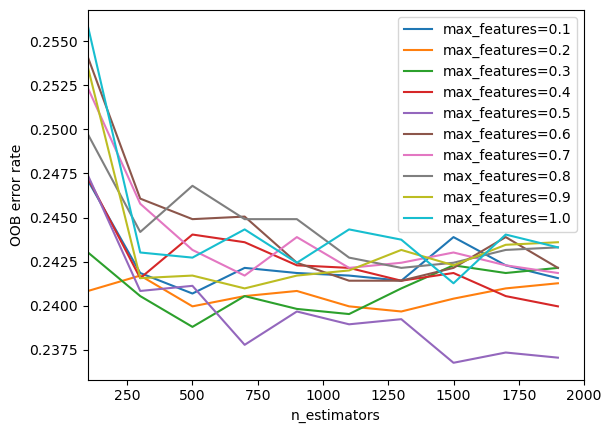

In [39]:
display_oob_error_rate(error_oob, min_estimators, max_estimators)

On remarque que le max_features à l'air de tendre vers une meilleur erreur oob.
On augmente le n_estimators pour confirmer cela

In [40]:
min_estimators = 100
max_estimators = 5000
a_max_features =  [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
step=500

In [41]:
error_oob = compute_oob_error_rate(min_estimators, max_estimators, step, a_max_features)

0.1
0.2
0.3
0.4
0.5
0.6
0.7
0.8
0.9
1.0


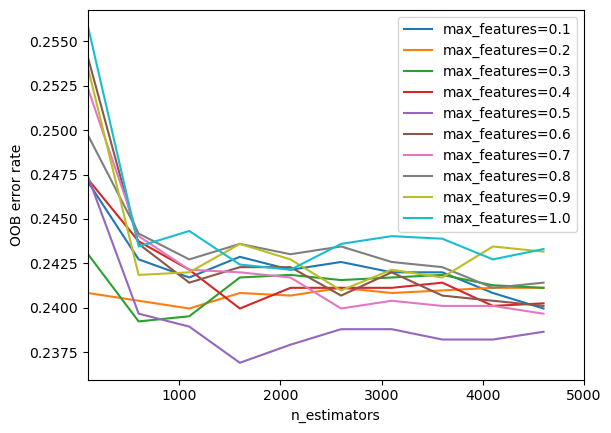

In [44]:
display_oob_error_rate(error_oob, min_estimators, max_estimators)

On voit bien le plateau, il est inutile de continuer au dela de 2000 estimators. On considèrera donc 1500 estimators et 0.5 de max_features.

In [ ]:
#Librairie pour mesurer le temps d'exécution
import time

Nous allons donc comparer les paramètres par défauts de sci kit (n_estimators = 100, max_features = sqrt(d)) et nos paramètres qui sont censés donner de meilleurs résultats. 
On va retirer le random state pour pouvoir généraliser sur 10 itérations et pour aussi pouvoir mesurer les temps d'apprentissage.

In [50]:
#RandomForest par défaut
time_start = time.time()
defaults_oob = []
for i in range(1, 11):
    rf = RandomForestClassifier(oob_score=True, n_jobs=-1)
    rf.fit(X_train, y_train)
    defaults_oob.append(rf.oob_score_)
time_end = time.time()
default_time = time_end - time_start

In [51]:
#RandomForest avec max_features=0.5 et n_estimators=1500
time_start = time.time()
best_oob = []
for i in range(1, 11):
    rf = RandomForestClassifier(oob_score=True, n_estimators=1500, max_features=0.5, n_jobs=-1)
    rf.fit(X_train, y_train)
    best_oob.append(rf.oob_score_)
time_end = time.time()
best_time = time_end - time_start

In [59]:
print(f"Default RandomForest score: {np.mean(defaults_oob):.3f} en {default_time/10:.2f} secondes en average")
print(f"Best RandomForest score: {np.mean(best_oob):.3f} en {best_time/10:.2f} secondes en average")

Default RandomForest score: 0.753 en 0.35 secondes en average
Best RandomForest score: 0.759 en 20.38 secondes en average


Notre forêt aléatoire est donc légèrement meilleure. Il faut par contre concéder un peu de temps de calcul car on parle de ~ 58x plus long.

On regarde maintenant l'importance des variables. On va utiliser la permutation et regarder la MDA. Notre problème n'étant pas d'envergure énorme le coût de calcul que les permutations engendrent sont correctes 

In [10]:
#MDA par permutation
from sklearn.inspection import permutation_importance
rf = RandomForestClassifier(n_estimators=1500, max_features=0.5, n_jobs=-1)
rf.fit(X_train, y_train)
result = permutation_importance(rf, X_val, y_val, n_repeats=10, random_state=42, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

In [11]:
def plot_feature_importances(importances, names, model_type):
    feature_importances = importances
    feature_names = names

    data={'feature_names':feature_names,'feature_importance':feature_importances}
    fi_df = pd.DataFrame(data)

    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    plt.figure(figsize=(10,20))
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    plt.title(model_type + ' Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Features')

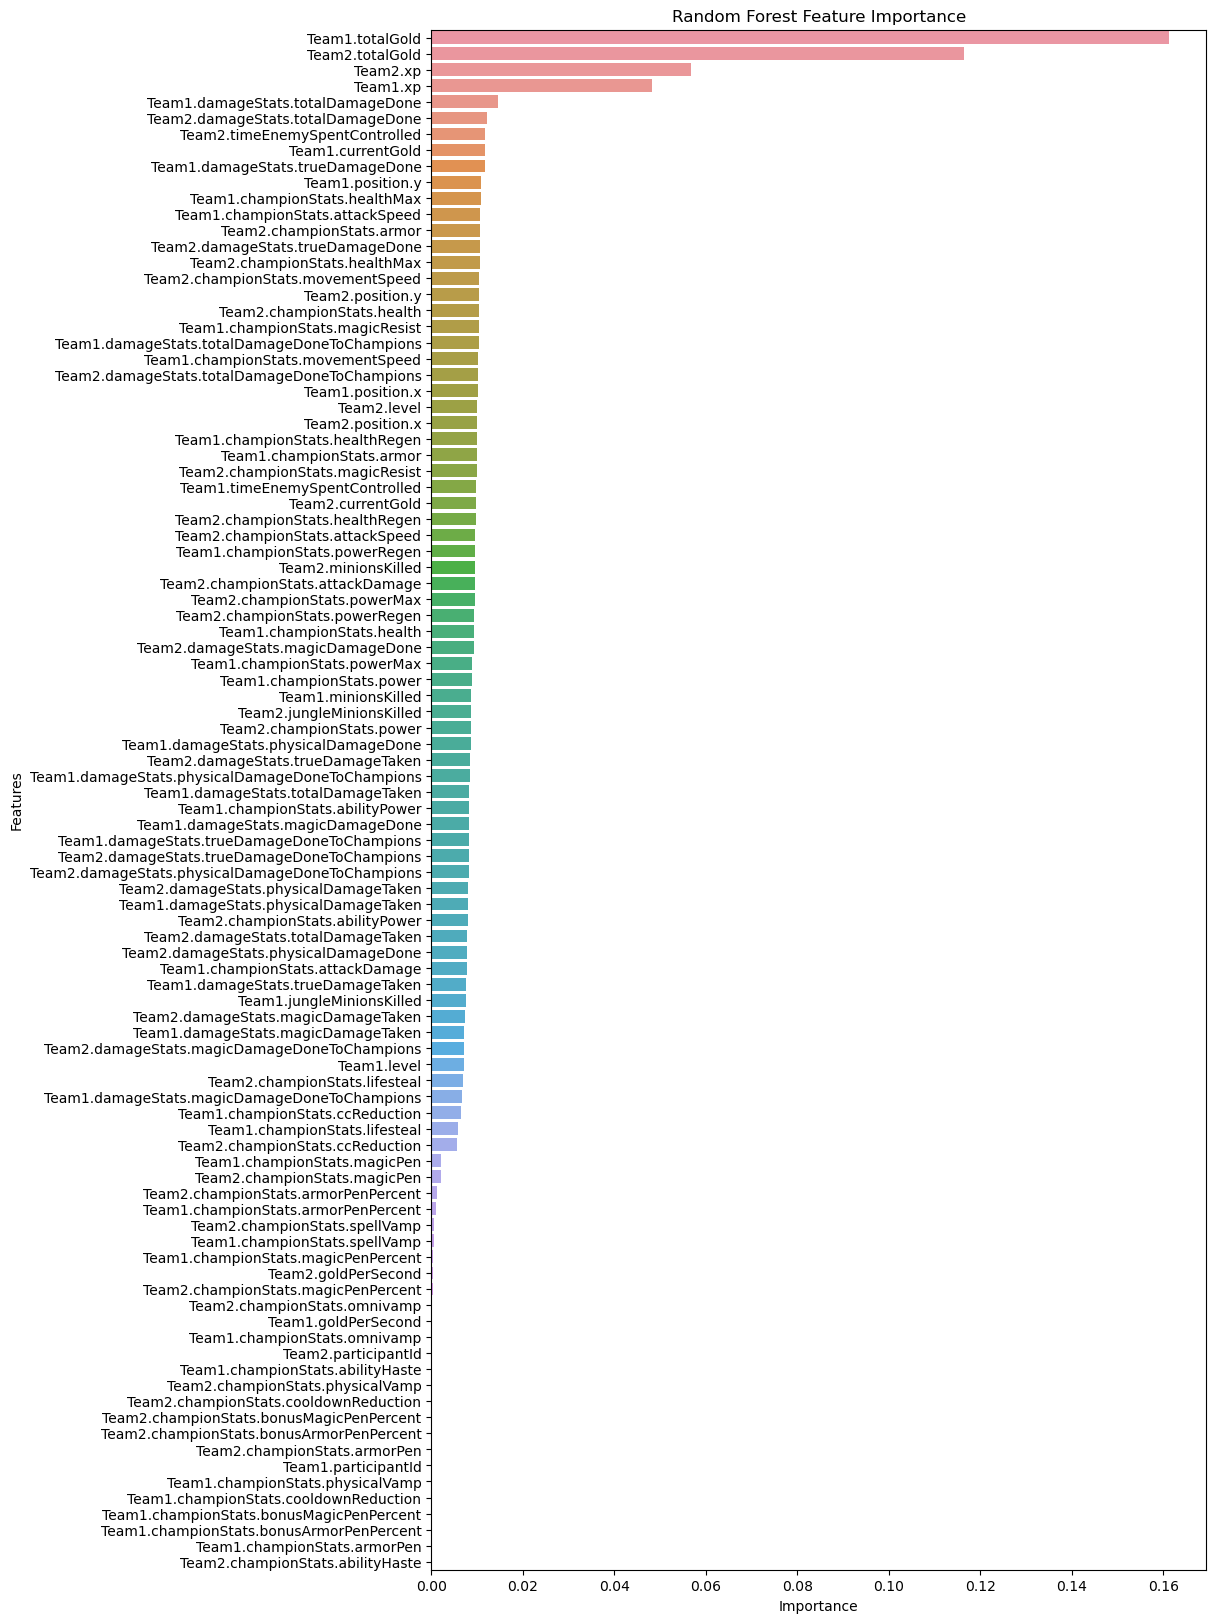

In [12]:
plot_feature_importances(rf.feature_importances_, X_test.columns, 'Random Forest')

In [44]:
to_remove = X_test.columns[sorted_idx[:94]]
to_remove

Index(['Team1.xp', 'Team2.championStats.powerRegen',
       'Team2.championStats.powerMax', 'Team2.championStats.power',
       'Team2.championStats.omnivamp', 'Team2.championStats.movementSpeed',
       'Team2.championStats.magicResist',
       'Team2.championStats.magicPenPercent', 'Team2.championStats.spellVamp',
       'Team2.championStats.magicPen', 'Team2.championStats.healthRegen',
       'Team2.championStats.healthMax', 'Team2.championStats.health',
       'Team2.championStats.ccReduction', 'Team2.championStats.attackSpeed',
       'Team2.championStats.attackDamage', 'Team2.championStats.armor',
       'Team2.championStats.lifesteal', 'Team2.currentGold',
       'Team2.damageStats.magicDamageDone',
       'Team2.damageStats.magicDamageDoneToChampions',
       'Team2.timeEnemySpentControlled', 'Team2.position.y',
       'Team2.position.x', 'Team2.minionsKilled', 'Team2.level',
       'Team2.jungleMinionsKilled', 'Team2.goldPerSecond',
       'Team2.damageStats.trueDamageTaken',


In [45]:
subset_data = data.drop(columns=to_remove, errors='ignore')
subset_data

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[9818 rows x 0 columns]

In [46]:
#test le modèle sur notre nouveau dataset
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(subset_data, target, test_size=0.3, random_state=42)

In [47]:
rf = RandomForestClassifier(n_estimators=550, max_features=0.5, oob_score=True, n_jobs=-1, random_state=42)
rf.fit(X_train_subset, y_train_subset)
subset_oob_accuracy = rf.score(X_test_subset, y_test_subset)
print("OOB score : ", rf.oob_score_)
print("Test score : ", subset_oob_accuracy)

ValueError: at least one array or dtype is required

In [ ]:
#Différence entre les deux scores
print("Différence entre les deux scores : ", test_accuracy - subset_oob_accuracy)

Différence entre les deux scores :  0.04243041412084181


In [ ]:
oob_accuracys_var = []

In [ ]:
for i in range(96):
    subset_data = data.drop(columns=to_remove[:i], errors='ignore')
    X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(subset_data, target, test_size=0.3, random_state=42)
    rf = RandomForestClassifier(n_estimators=550, max_features=0.5, oob_score=True, n_jobs=-1, random_state=42)
    rf.fit(X_train_subset, y_train_subset)
    subset_oob_accuracy = rf.score(X_test_subset, y_test_subset)
    oob_accuracys_var.append(subset_oob_accuracy)

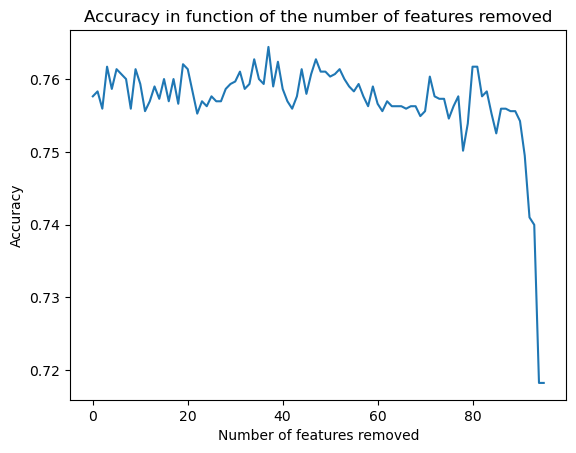

In [ ]:
#Courbe of the accuracy in function of the number of features
plt.plot(range(96), oob_accuracys_var)
plt.xlabel('Number of features removed')
plt.ylabel('Accuracy')
plt.title('Accuracy in function of the number of features removed')
plt.show()

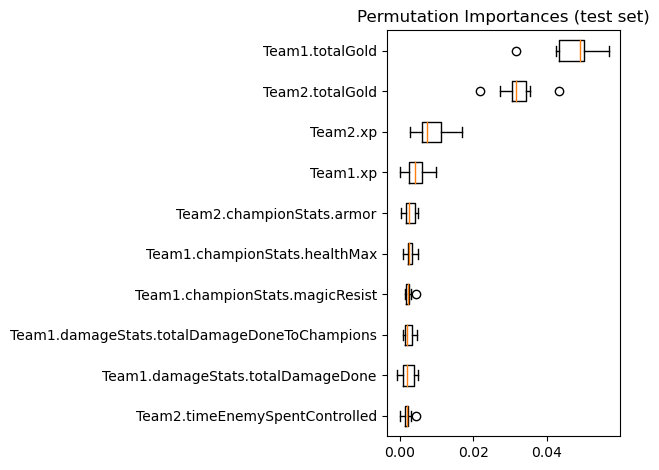

In [ ]:
#On garde les 10 features les plus importantes
sorted_idx = result.importances_mean.argsort()[data.shape[1]-10:]

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

# flop